In [238]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv
import seaborn as sns
from matplotlib.axis import Axis
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#from moepy import lowess
from numpy import mean, absolute
import scipy.stats as ss

Change RMSSD Length from 100 -> 25 and same for subj subset df

# Process Information Taken from Raw Files

## Import our Previously Extracted Data

In [2]:
record_list = [] # Initialize the array that will hold the list of our records

records = 'mit-bih-dataframes/subject_list.csv' # Get our record list like we did in the initial extraction
with open(records) as rfile:# Load our records into the array
    for record in rfile:
        record = record[0:-1] # The -1 removes the newline ("\n") character from the string
        record_list.append(record)

In [3]:
subject_dataframes = [] # Initialize our dataframe array

for x in tqdm(record_list): # Extract our dataframes from the CSVs we saved previously
    subject_dataframes.append(pd.read_csv('mit-bih-dataframes/'+x+'.csv', index_col=0))
            # 'index_col=0' loads the index that is saved into the csv as the index rather than another column

  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\NNL\anacondareal\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
100%|██████████| 23/23 [01:34<00:00,  4.09s/it]


In [4]:

# Now we get the indexes of the R-Peaks from our dataframes
qrs = [] # Initialize the array that will hold our list of R-Peaks for each subject

for subject in tqdm(subject_dataframes): # Load each subject
    qrs.append([idx for idx, x in enumerate(subject['R-Peak']) if x]) # Then we use list comprehension to get our r peaks for each subject
                                                                # Recall, the indices that the R-Peak column is true is where there is an r-peak
                                                                # So, we iterate through and identify which indices that is for each subject

100%|██████████| 23/23 [00:22<00:00,  1.00it/s]


In [5]:
#print(subject_dataframes[1])
#print(qrs[1])

## Extract RR-Intervals

In 2019, all of our developed variables were based on RR-Intervals, or the distance between adjacent R-Peaks. So, that is the first thing we extract 

In [6]:
rr_ints = [] # Initialize the array that will hold all of our subjects' RR-Intervals

# Then we want to Go through all of our data that holds our R-Peaks [That will be the qrs array]
# Iterating through that we want to extract the interval between each peak. 
# My suggested format is: 
"""
for each subject:
    for each rpeak sample_num in my current subject:
        subject_rrinterval.append( rpeak sample_num - the sample_num before it)
"""
for subject in tqdm(qrs):
    temp_array = []
    for index, rpeak in enumerate(subject):
        if index != 0:
            temp_array.append(rpeak - subject[index-1])
    rr_ints.append(temp_array)
#print(rr_ints[0])

100%|██████████| 23/23 [00:00<00:00, 76.08it/s]


In [7]:
rr_timeints = []
for subject in rr_ints:
    subject_time = []
    for interval in subject:
        time = interval/250
        if time <= 2 and time >= (1/3):
            subject_time.append(time)
        else:
            subject_time.append(-1)
    rr_timeints.append(subject_time)

In [8]:
#from Tutorial_Extract_MIT-BIH import atr_labels
subject_list = []
for integer in tqdm(range(0, 23)):    
    df = pd.DataFrame(
        {
            "Interval": rr_timeints[integer],
            "R-Peak": qrs[integer][1:],
            "Afib": subject_dataframes[integer]['AFIB'][qrs[integer][1:]],
            "Normal": subject_dataframes[integer]['Normal'][qrs[integer][1:]],
            "Other": subject_dataframes[integer]['Other'][qrs[integer][1:]],
    #        "Rhythm": main_list,
    #        'Indexes': index_list
        }
    )
    typelist = ['Normal', 'Afib', 'Other']
    main_list = []
    for index, row in df.iterrows():
        for types in typelist:
                if types == 'Normal' and row['Normal']:
                    main_list.append('N')
                elif types == 'Afib' and row['Afib']:
                    main_list.append('A')
                elif types == 'Other' and row['Other']:
                    main_list.append('O')
    df = df.assign(Rhythm=main_list)
    df = df.query('Interval != -1')
    subject_list.append(df)

100%|██████████| 23/23 [01:19<00:00,  3.44s/it]


 87%|████████▋ | 20/23 [00:03<00:00,  6.59it/s]<ipython-input-9-2273d1c8d47c>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3)) #plot subplots
100%|██████████| 23/23 [00:03<00:00,  6.16it/s]


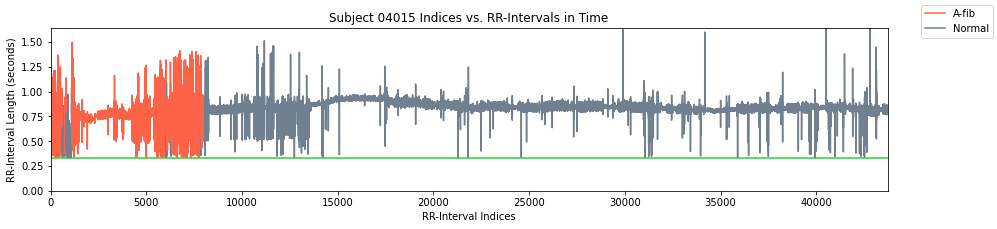

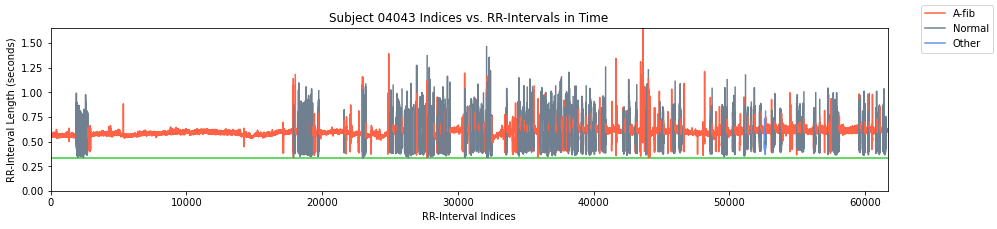

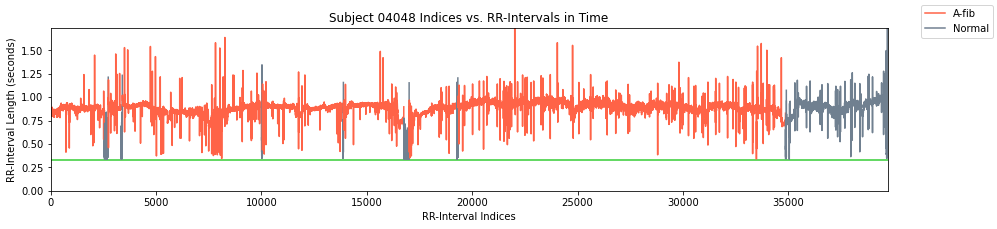

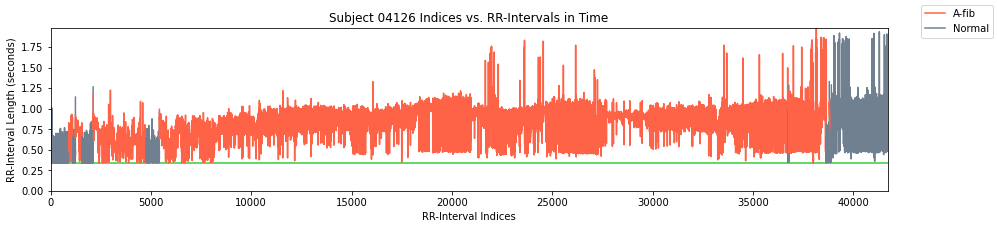

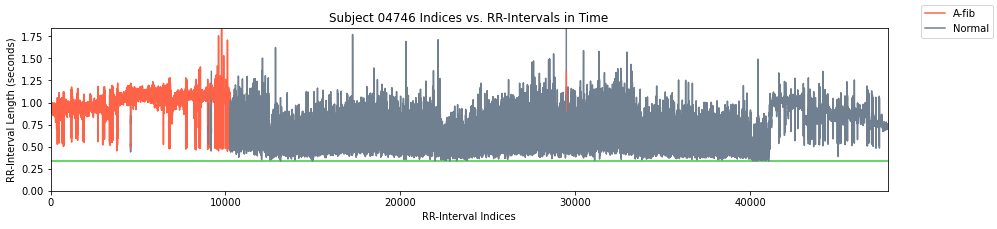

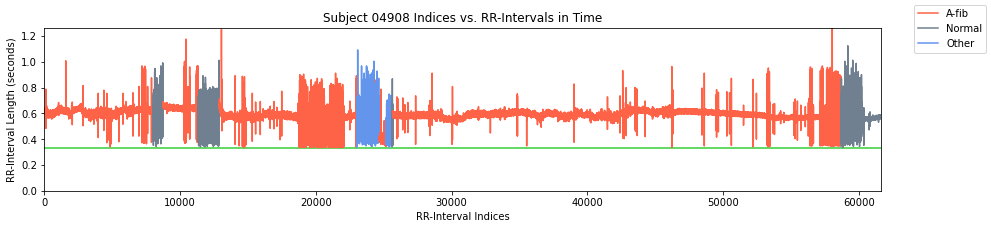

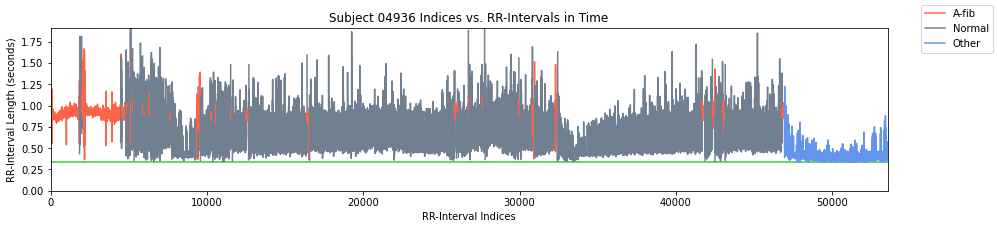

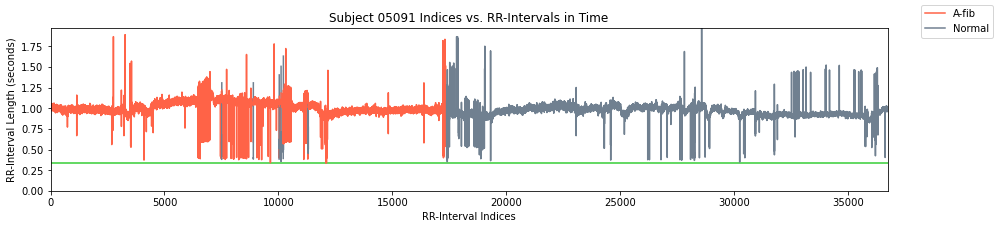

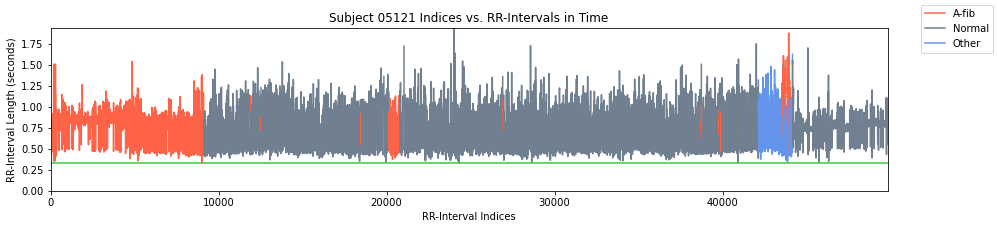

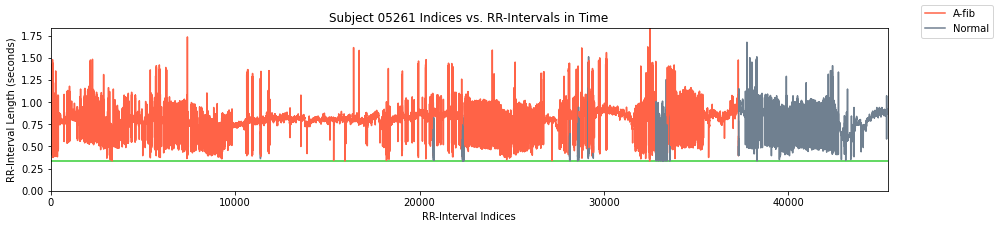

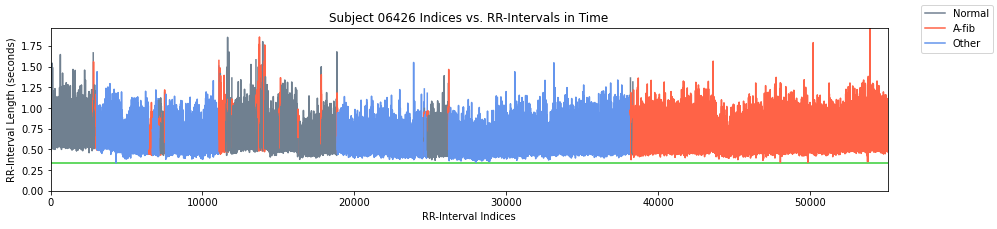

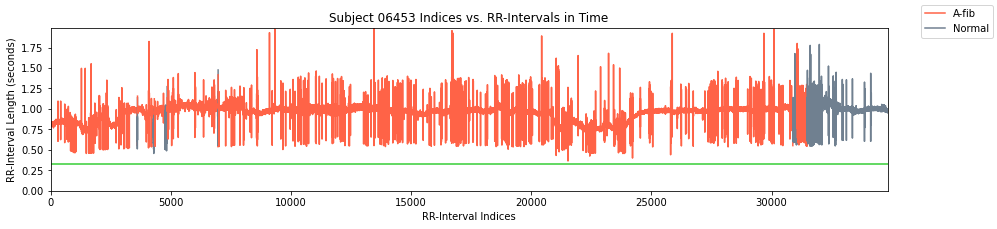

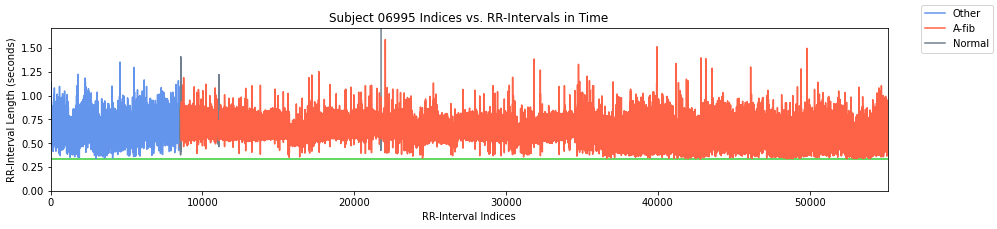

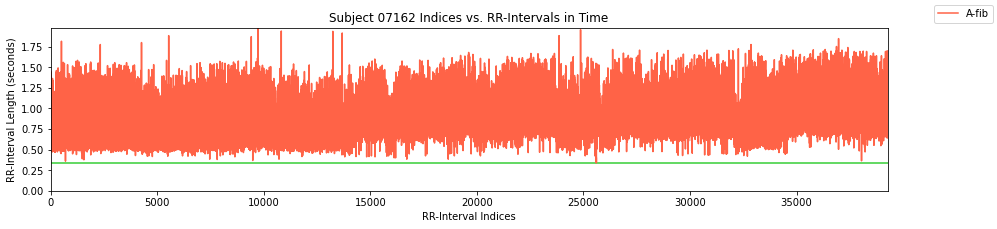

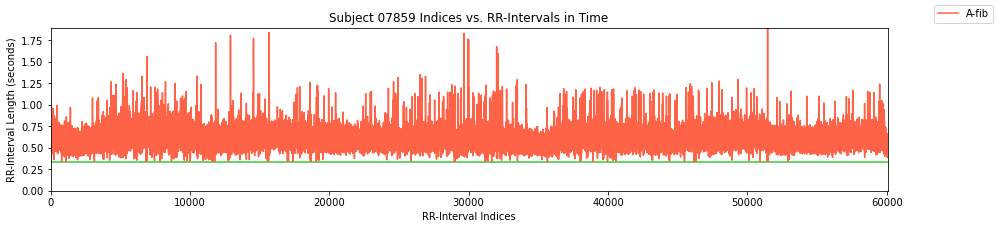

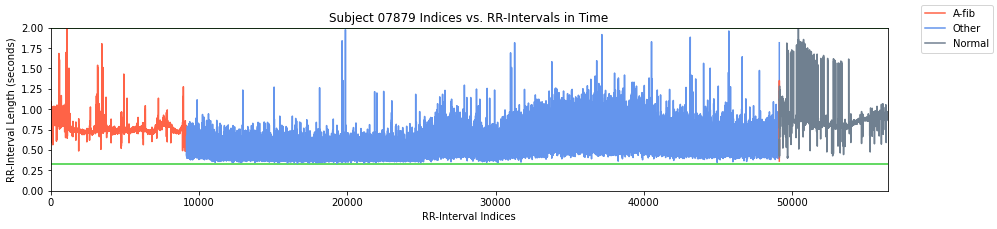

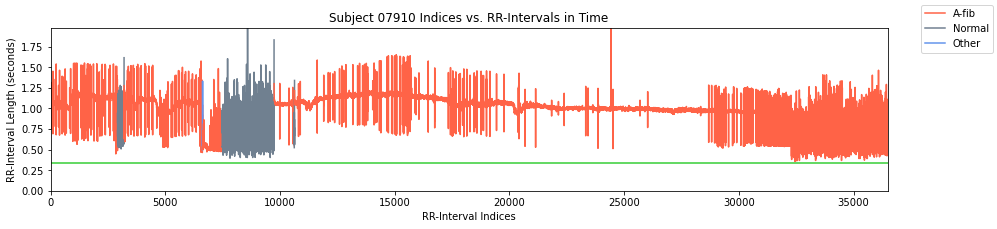

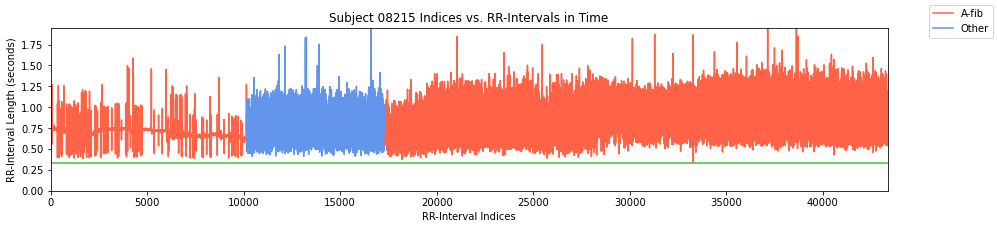

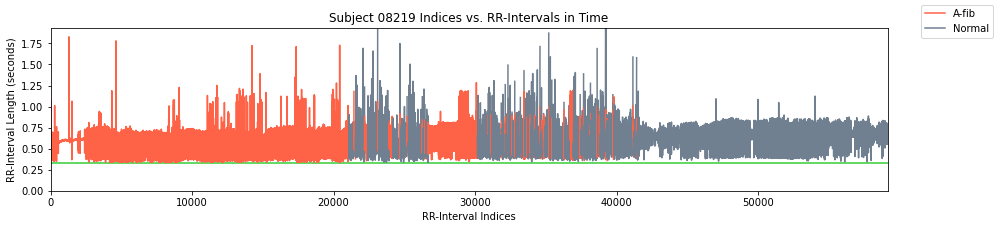

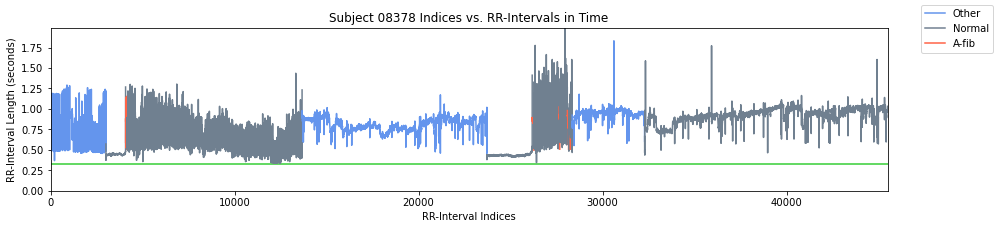

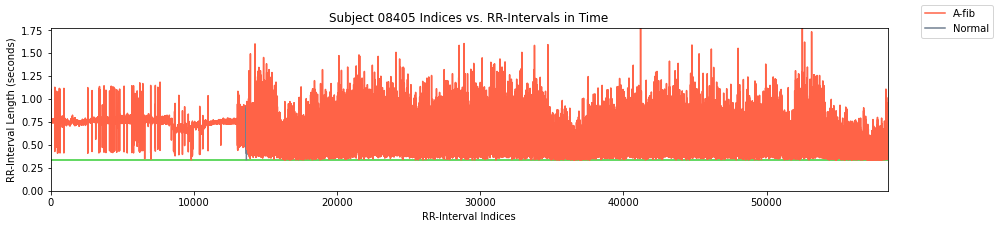

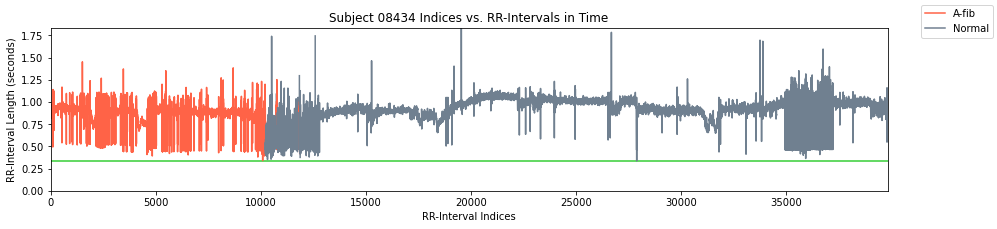

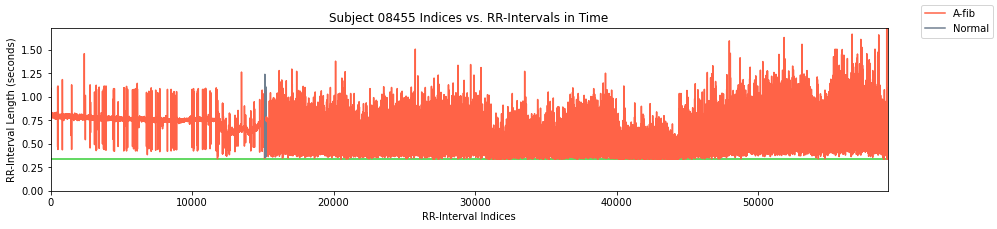

In [9]:
comp = '' #Compare when df['Rhythm'] changes from normal to Afib
counter = 0 #Upper bound for line
mini = 0 #(Minimum) Lower bound for line
subject_counter = 0 #Retrieve the specific subject array from rr_timeints
#labels = 'Red = A-fib, Black = Normal, Green = Other'
overlapping = 1
for df in tqdm(subject_list): #iterate through all subjects
    
    comp = ''
    counter = 0
    mini = 0
    ins_norm_counter = 0 #for figure legend
    ins_other_counter = 0 #for figure legend
    ins_afib_counter = 0 #for figure legend
    fig, axs = plt.subplots(figsize=(15,3)) #plot subplots
    plt.title('Subject ' + record_list[subject_counter] + ' Indices vs. RR-Intervals in Time')
    plt.xlabel('RR-Interval Indices')
    plt.ylabel('RR-Interval Length (seconds)')
    axs.set_xlim([0, len(df)])
    axs.set_ylim([0, max(df['Interval'])])
    
    #Set x and y for line of best fit
#     upper = len(df['Rhythm'])
#     indices_list = []
#     for num in range(0, upper):
#         indices_list.append(num)
#     x = np.array(indices_list)
#     y = df['Interval']#df['Interval']
    
    #find line of best fit
    #a, b = np.polyfit(x, y, 1)
    
#     lowess_model = lowess.Lowess()
#     lowess_model.fit(x, y)

#     # Model prediction
#     print('before')
#     x_pred = np.linspace(0, 65000, 100)
#     print('between')
#     y_pred = lowess_model.predict(x_pred)

#     # Plotting
#     plt.plot(x_pred, y_pred, '--', label='LOWESS', color='k', zorder=3)
#     plt.scatter(x, y, label='Noisy Sin Wave', color='C1', s=5, zorder=1)
#     plt.legend(frameon=False)

#     print('Hello')
    plt.axhline(y=2, color='limegreen', linestyle='-')
    plt.axhline(y=1/3, color='limegreen', linestyle='-')
    
    
    for item in df['Rhythm']: #iterate through each letter (rhythm) in each dataframe for each subject
        
        counter += 1
        
        if item != comp and comp != '':
            
            if item == 'N':
                if ins_norm_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='slategrey',label = 'Normal', alpha=overlapping)
                    ins_norm_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='slategrey', alpha=overlapping)
            
            if item == 'O':
                if ins_other_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='cornflowerblue',label = 'Other', alpha=overlapping)
                    ins_other_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='cornflowerblue', alpha=overlapping)
            
            if item == 'A':
                if ins_afib_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='tomato',label = 'A-fib', alpha=overlapping)
                    ins_afib_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='tomato', alpha=overlapping)
            mini = counter #resets starting x to new one
        
        elif counter == len(df['Rhythm']):
            
            if item == 'N':
                if ins_norm_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='slategrey',label = 'Normal', alpha=overlapping)
                    ins_norm_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='slategrey', alpha=overlapping)
            
            if item == 'O':
                if ins_other_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='cornflowerblue',label = 'Other', alpha=overlapping)
                    ins_other_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='cornflowerblue', alpha=overlapping)
            
            if item == 'A':
                if ins_afib_counter == 0:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='tomato',label = 'A-fib', alpha=overlapping)
                    ins_afib_counter += 1
                else:
                    axs.plot(range(mini, counter), df['Interval'][mini:counter], color='tomato', alpha=overlapping)
        
        comp = item #comparator for each item in df['Rhythm']
    subject_counter += 1
    fig.legend(loc='upper right') #show legends
    
    #add line of best fit to plot
    #l1 = plt.plot(x, a*x+b, color='lime',linewidth=3)

        
plt.show()

In [10]:
#SEE HISTOGRAMS BELOW 

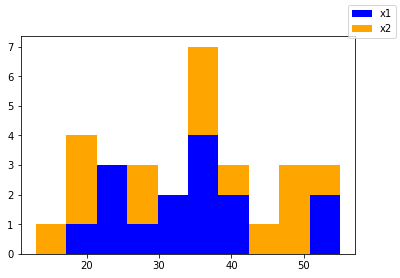

In [11]:
#Example for how to stack histograms

x1= [23, 25, 40, 35, 40, 53, 33, 28, 55, 34, 20, 37, 36, 23, 33]
x2= [36, 20, 27, 50, 34, 47, 18, 28, 52, 21, 44, 34, 13, 40, 49]
colors = ['blue', 'orange']
labels = ['x1', 'x2']
fig, axs = plt.subplots()
axs.hist([x1, x2], stacked = True, color=colors, label = labels)
#axs.hist([x1], stacked = True, color=colors[0], label = labels[0])

fig.legend(loc='upper right')

In [12]:
subject_list[0]

Interval   R-Peak   Afib  Normal  Other Rhythm
200         0.556      200  False    True  False      N
358         0.632      358  False    True  False      N
584         0.904      584  False    True  False      N
729         0.580      729  False    True  False      N
873         0.576      873  False    True  False      N
...           ...      ...    ...     ...    ...    ...
8999121     0.828  8999121  False    True  False      N
8999327     0.824  8999327  False    True  False      N
8999531     0.816  8999531  False    True  False      N
8999734     0.812  8999734  False    True  False      N
8999941     0.828  8999941  False    True  False      N

[43720 rows x 6 columns]

 87%|████████▋ | 20/23 [01:14<00:10,  3.59s/it]<ipython-input-13-a648e0b93e1e>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots()
100%|██████████| 23/23 [01:26<00:00,  3.76s/it]


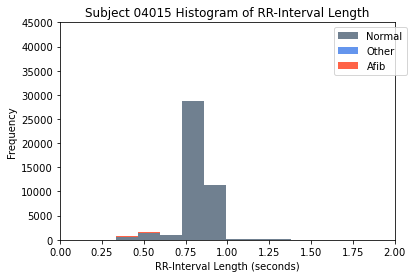

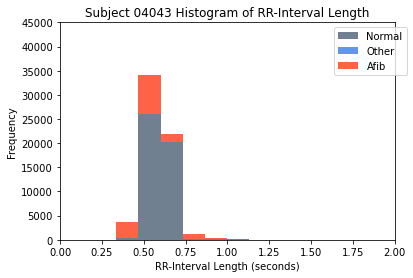

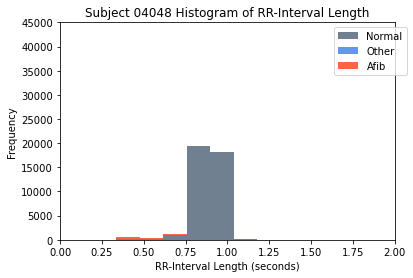

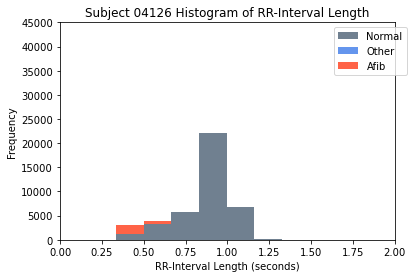

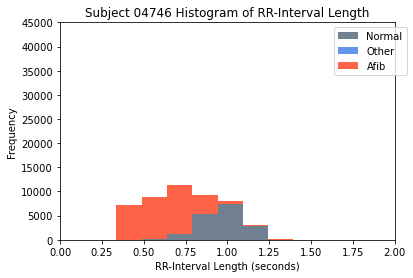

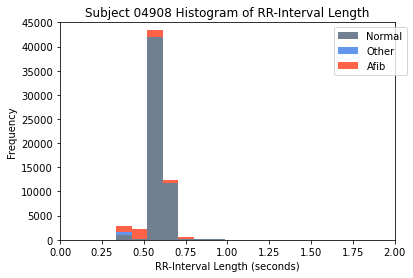

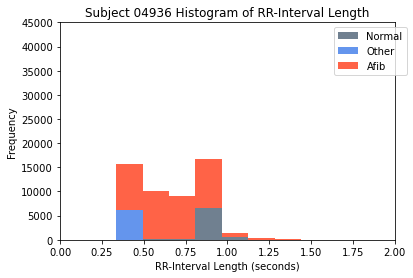

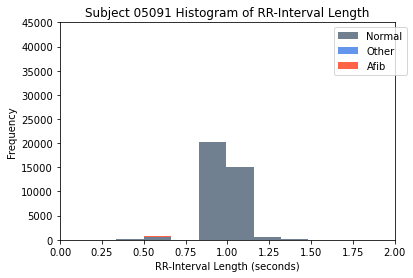

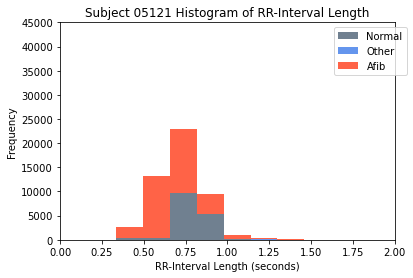

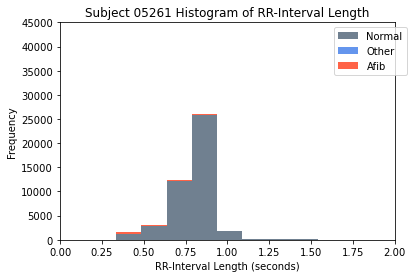

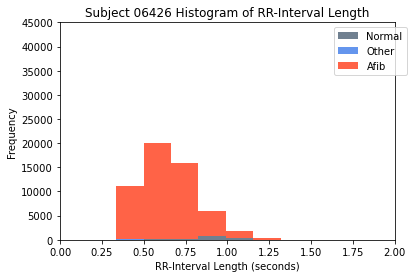

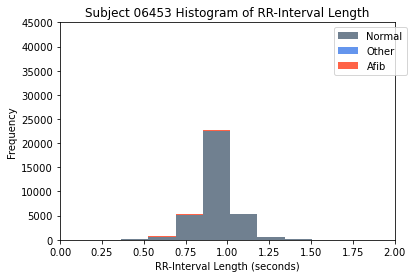

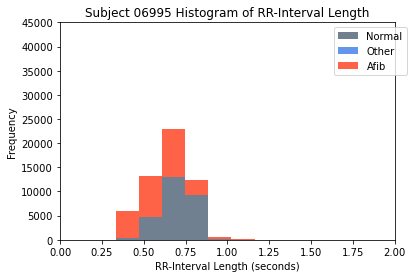

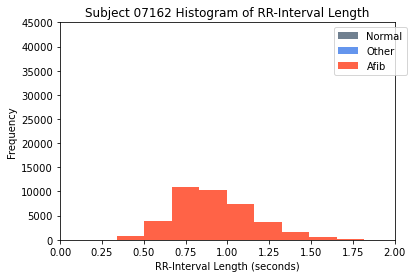

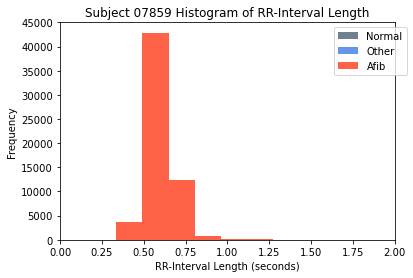

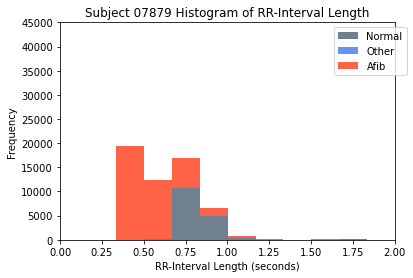

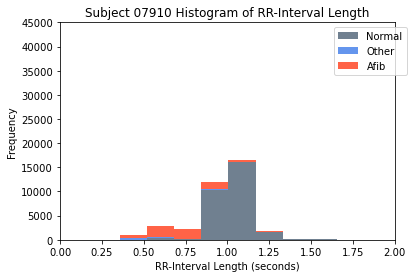

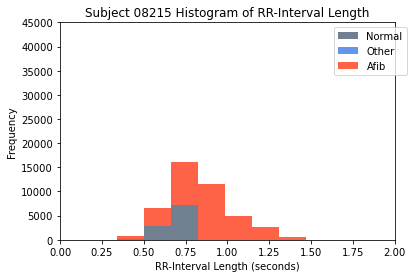

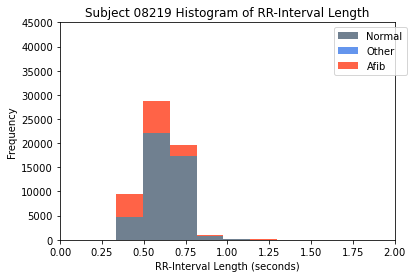

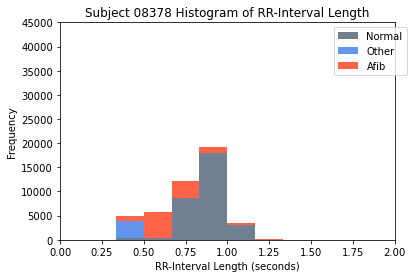

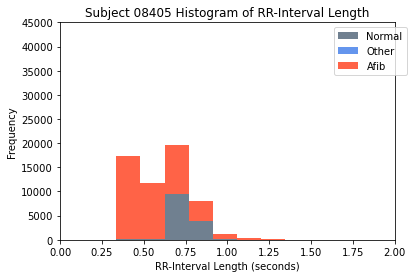

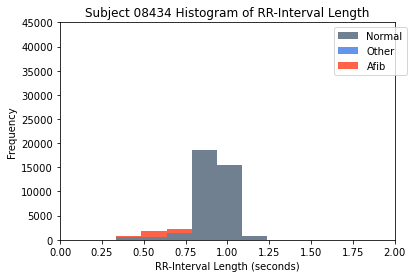

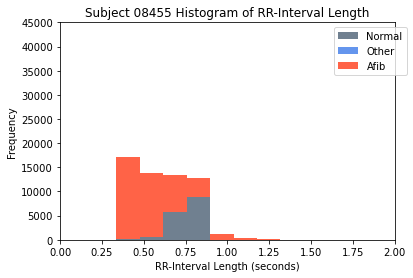

In [13]:
colors = ['slategrey', 'cornflowerblue', 'tomato']
labels = ['Normal', 'Other', 'Afib']
bins = 7
integer = 0
for df in tqdm(subject_list):
    normal_list = []
    other_list = []
    afib_list = []
    counter = 0
    
    fig, axs = plt.subplots()
    plt.title('Subject ' + record_list[integer] + ' Histogram of RR-Interval Length')
    plt.xlabel('RR-Interval Length (seconds)')
    plt.ylabel('Frequency')
    axs.set_xlim(0, 2)
    axs.set_ylim(0, 45000)
    
    for idx, item in df.iterrows():
        if item['Rhythm'] == 'N':
            normal_list.append(df['Interval'].loc[idx])
            counter += 1
        elif item['Rhythm'] == 'O':
            other_list.append(df['Interval'].loc[idx])
            counter += 1
        elif item['Rhythm'] == 'A':
            afib_list.append(df['Interval'].loc[idx])
            counter += 1
    integer += 1
    axs.hist([normal_list, other_list, afib_list], stacked = True, color=colors, label = labels)
    #fig.legend(loc='upper right')
    axs.legend(bbox_to_anchor=(1.05, 1))
    #axs.set_facecolor('limegreen')

In [14]:
type(subject_list[0])

pandas.core.frame.DataFrame

In [115]:
def subset_subject(subjdf, interval_length = 25):
    interval_list = []
    subset_list = []
    counter = 0
    for item in subjdf['Interval']:
        subset_list.append(item)
        counter += 1
        if counter == interval_length:
            interval_list.append(subset_list)
            subset_list = []
            counter = 0
    rhythm_list = []
    rhythmsub_list = []
    counter = 0
    for item in subjdf['Rhythm']:
        rhythmsub_list.append(item)
        counter += 1
        if counter == interval_length:
            rhythm_list.append(rhythmsub_list)
            rhythmsub_list = []
            counter = 0
    subsetdf = []
    for index, item in enumerate(interval_list):
        newdf = pd.DataFrame(
            {
                'Interval':item,
                'Rhythm':rhythm_list[index]
            }
        )
        subsetdf.append(newdf)
    return subsetdf



def rmean(subsetdf):
    rmean_total = []
    for item in subsetdf:
        rmean_list = []
        rmean_cur = .75 + 0.25 * item['Interval'][0]
        rmean_list.append(rmean_cur)
        rmean_pre = rmean_cur
        for num in range(1,len(item)):
            rmean_cur = .75 * rmean_pre + 0.25 * item['Interval'][num]
            rmean_list.append(rmean_cur)
            rmean_pre = rmean_cur
        rmean_total.append(rmean_list)
    return rmean_total


def drmean(subsetdf):
    drmean_total = []
    for item in subsetdf:
        drmean_list = []
        rmean_cur = .75 + 0.25 * item['Interval'][0]
        drmean = 0
        drmean_list.append(drmean)
        rmean_pre = rmean_cur
        for num in range(1,len(item)):
            rmean_cur = .75 * rmean_pre + 0.25 * item['Interval'][num]
            drmean = rmean_cur - rmean_pre
            drmean_list.append(drmean)
            rmean_pre = rmean_cur
        drmean_total.append(drmean_list)
    return drmean_total

def variance_func(chunk):
    mean = np.mean(chunk['Interval'])
    templist = []
    for value in chunk['Interval']:
        residual = value - mean
        residual = residual ** 2
        templist.append(residual)
    tempvar = np.std(templist)
    return tempvar

def prob_chunk(chunk):
    s_counter = 0
    r_counter = 0
    l_counter = 0
    for index, num in enumerate(chunk['Interval']):
        if num < 0.85 * chunk['rmean'][index]:
            #if rr_ints is less than 85% of runningmean
            #label subject type as short
            #subset_types.append('short')
            s_counter += 1
        elif num > 1.15 * chunk['rmean'][index]:
            #if rr_ints is greater than 115% of runningmean
            #label subject type as long
            #subset_types.append('long')
            l_counter += 1
        else:
            #label subject type as regular
            #subset_types.append('regular')
            r_counter += 1
    #temp_list = [norm_chunk, other_chunk, afib_chunk]
    #maximum = max(temp_list)
    denom = s_counter + r_counter + l_counter
    #print(norm_chunk, other_chunk, afib_chunk)
    prob = [s_counter/denom, r_counter/denom, l_counter/denom]
    return prob

In [116]:
subset_dataframes = []
for num in tqdm(range(0,23)):
    subjsubdf = subset_subject(subject_list[num])
    subrmean = rmean(subset_subject(subject_list[num]))
    subdrmean = drmean(subset_subject(subject_list[num]))
    for i in range(0,len(subjsubdf)):
        subjsubdf[i] = subjsubdf[i].assign(rmean=subrmean[i])
        subjsubdf[i] = subjsubdf[i].assign(drmean=subdrmean[i])
    subset_dataframes.append(subjsubdf)

100%|██████████| 23/23 [01:25<00:00,  3.71s/it]


In [117]:
# subject_mean = []
# for subject in tqdm(subset_dataframes):
#     for interval in subject:
#         temp_mean = 0
#         mean_list = []
#         for values in interval['Interval']:
#             temp_mean += values
#         temp_mean = temp_mean / len(interval['Interval'])
#         mean_list.append(temp_mean)
#     subject_mean.append(mean_list)


In [118]:
chunk_prob = []
for subject in tqdm(subset_dataframes):
    temp_chunk = []
    for chunks in subject:
        temp = prob_chunk(chunks)
        temp_chunk.append(temp)
    chunk_prob.append(temp_chunk)

transitionShEntropy_list = []
for subject in chunk_prob:
    chunk_shannon = []
    for chunk in subject:
        shannon_entropy = 0
        for individualprob in chunk:
            temp_var = np.log(individualprob ** individualprob)
            shannon_entropy += -temp_var
        chunk_shannon.append(shannon_entropy)
    transitionShEntropy_list.append(chunk_shannon)

100%|██████████| 23/23 [00:12<00:00,  1.80it/s]


In [119]:
#Chunk Volatility
volatility_main = []
for subject in tqdm(subset_dataframes):
    temp_list = []
    for chunk in subject:
        temp_var = variance_func(chunk)
        temp_list.append(temp_var)
    volatility_main.append(temp_list)

100%|██████████| 23/23 [00:03<00:00,  6.18it/s]


<ipython-input-120-719e73786532>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3))


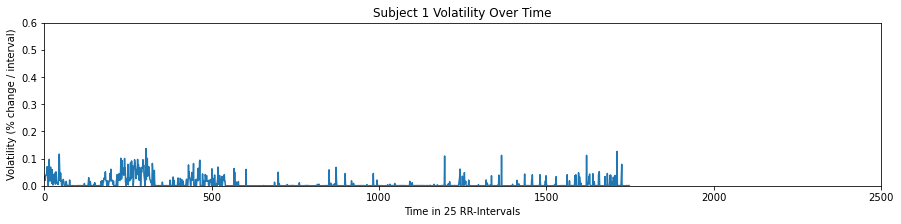

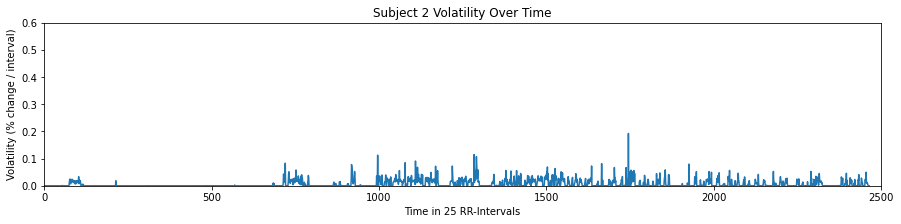

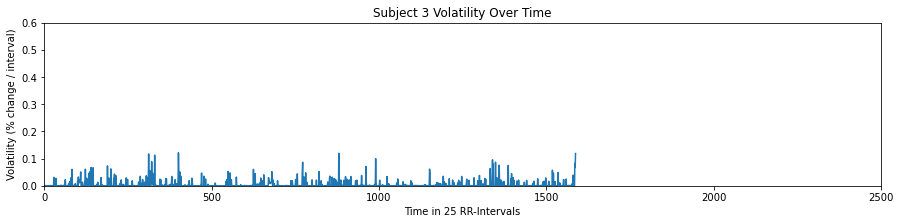

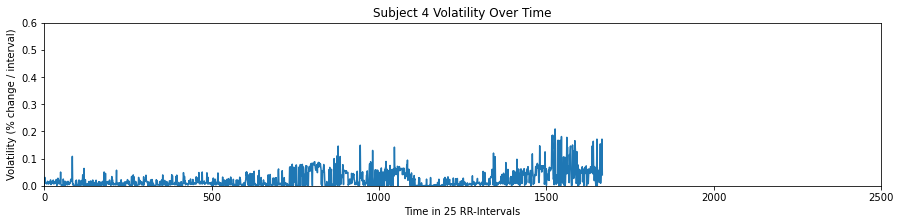

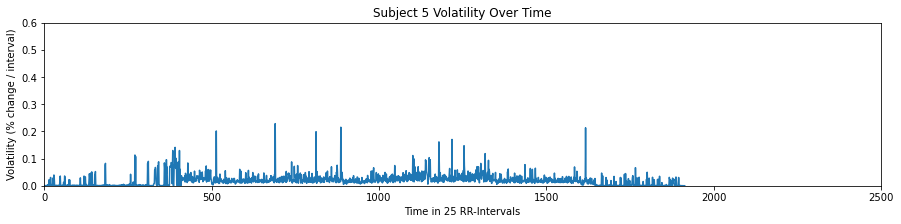

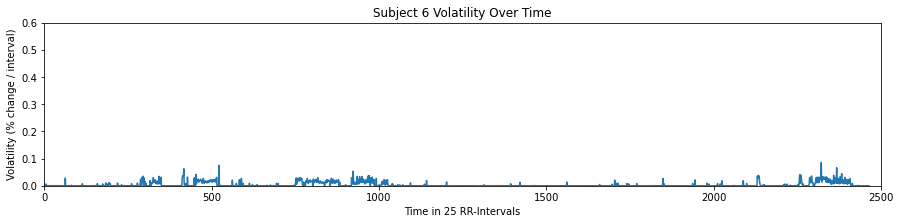

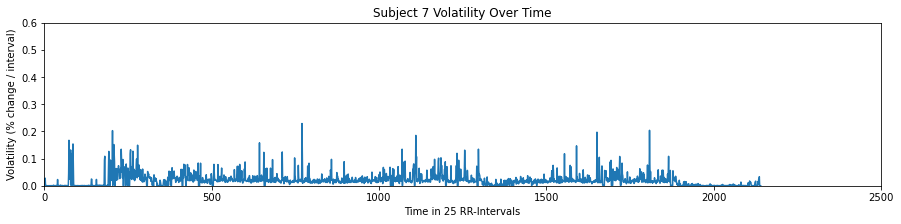

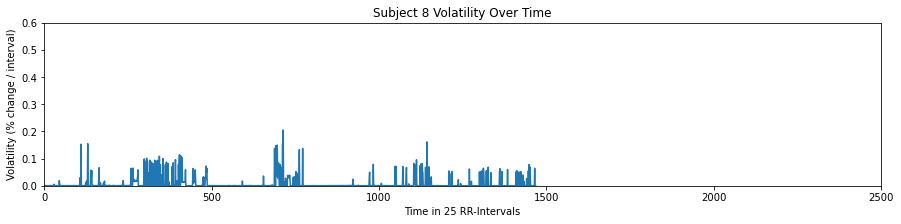

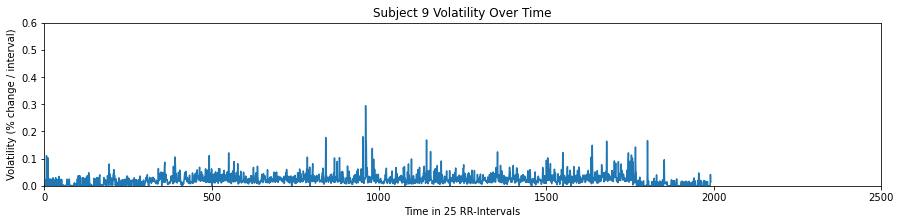

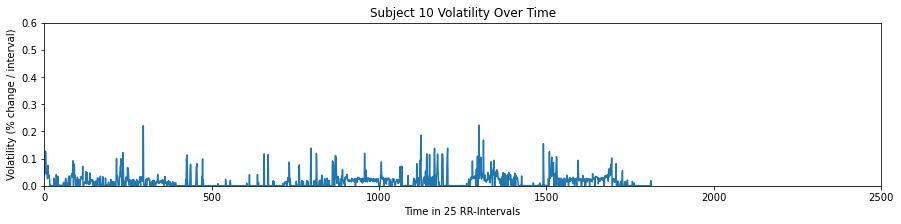

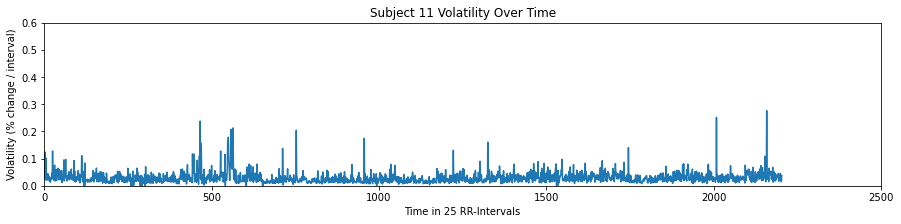

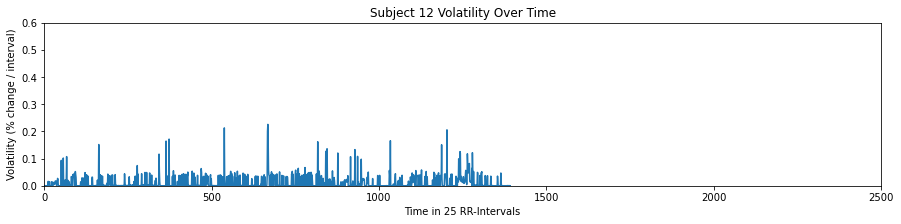

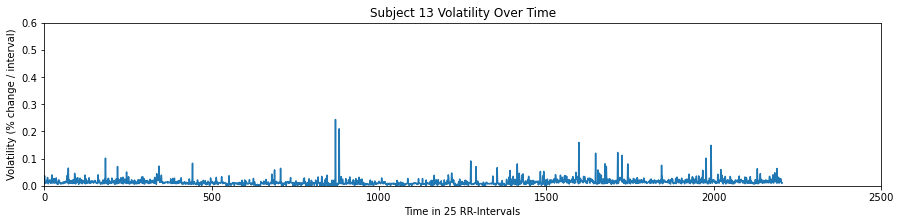

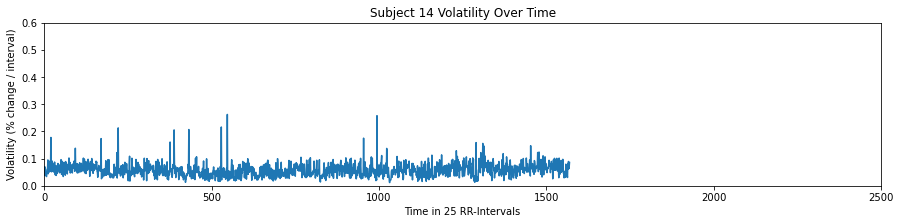

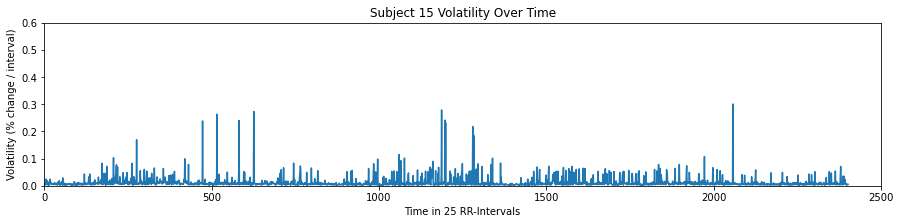

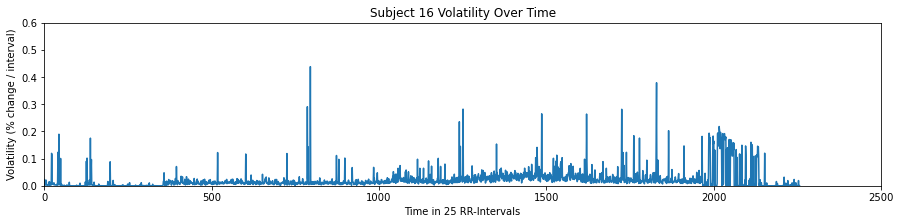

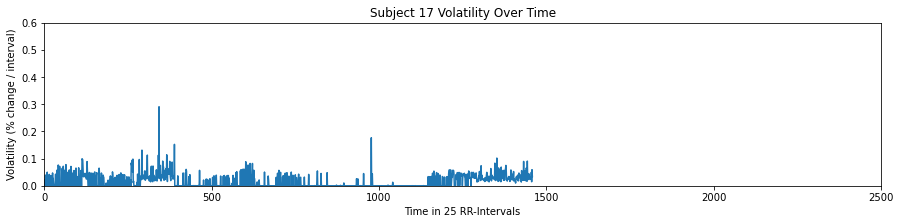

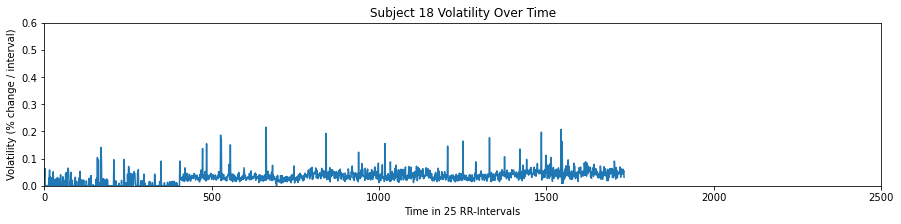

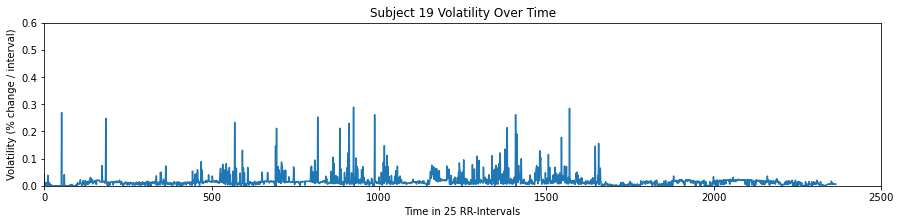

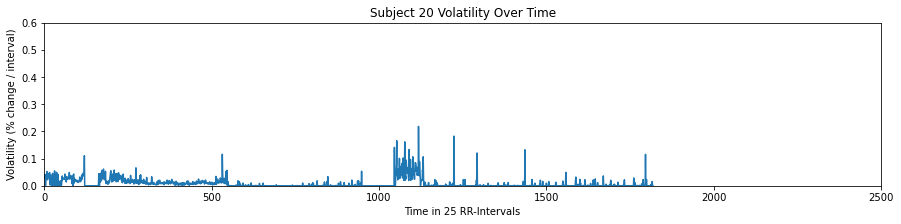

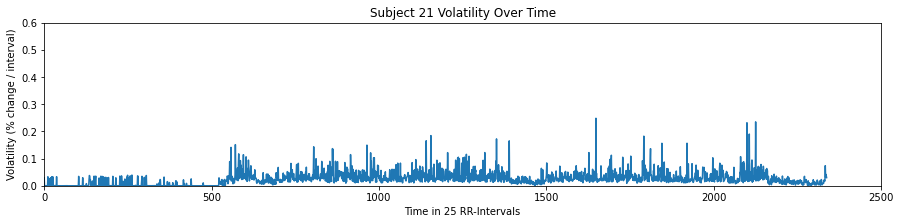

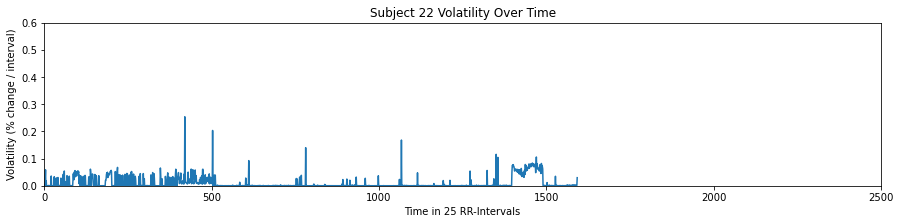

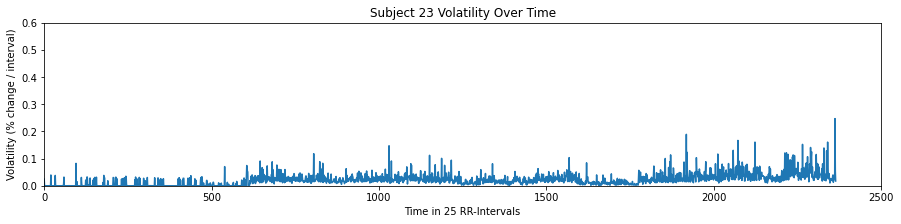

In [120]:
#fig, axs = plt.subplots()

for index, subject in enumerate(volatility_main):
    fig, axs = plt.subplots(figsize=(15,3))
    axs.plot(subject)
    plt.xlabel('Time in 25 RR-Intervals')
    plt.ylabel('Volatility (% change / interval)')
    plt.title('Subject ' + str(index + 1) + ' Volatility Over Time')
    axs.set_xlim([0, 2500])
    axs.set_ylim([0, 0.6])

<ipython-input-121-3f69f97cadb0>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3))


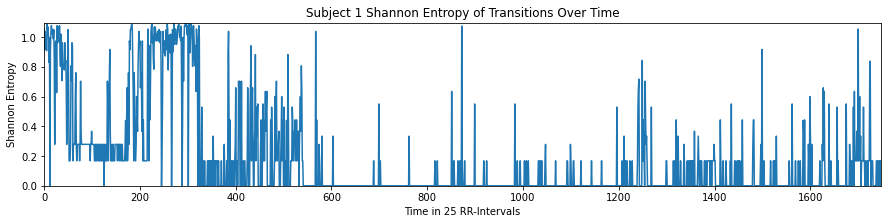

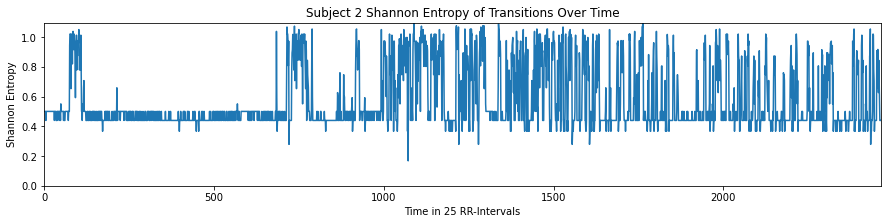

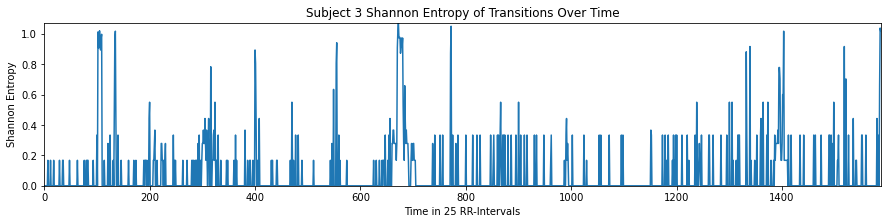

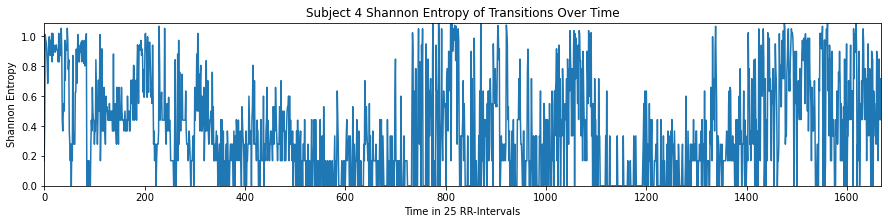

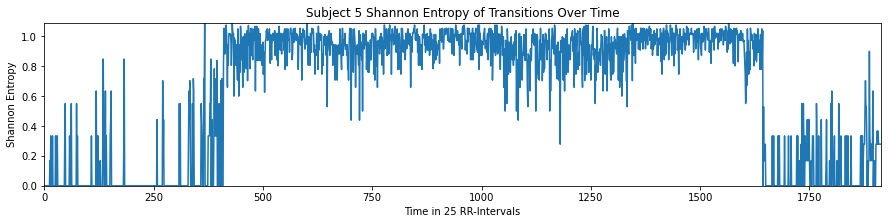

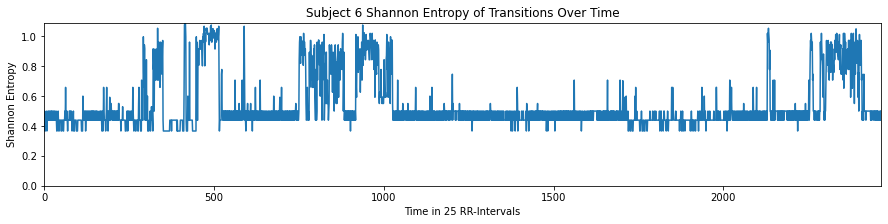

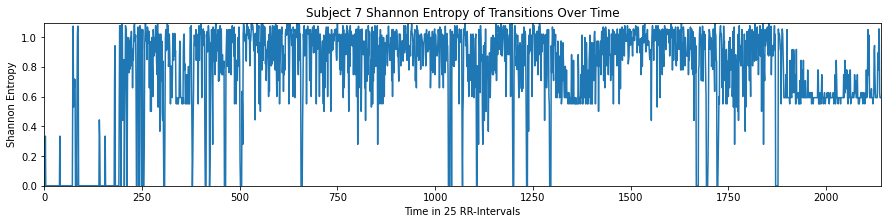

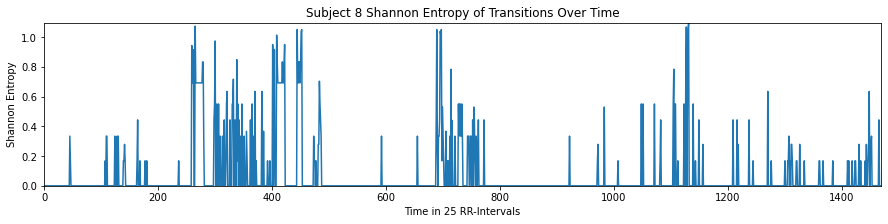

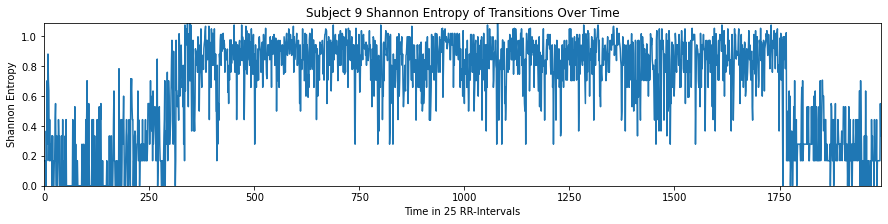

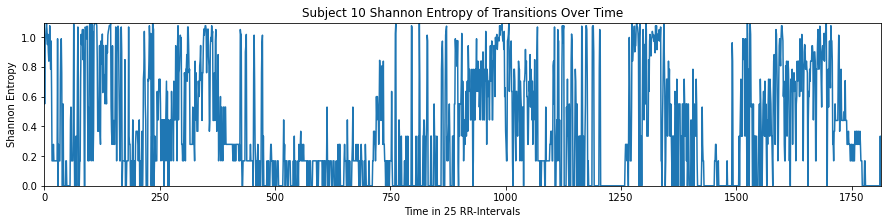

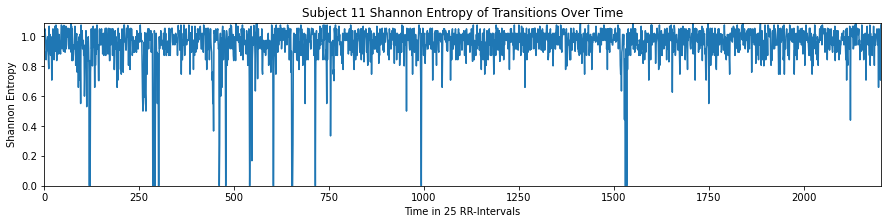

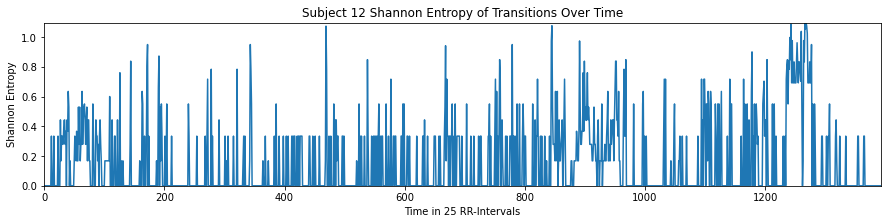

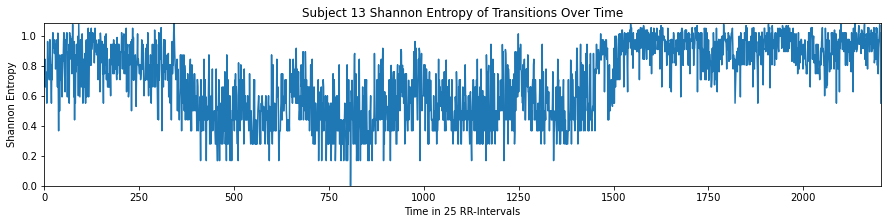

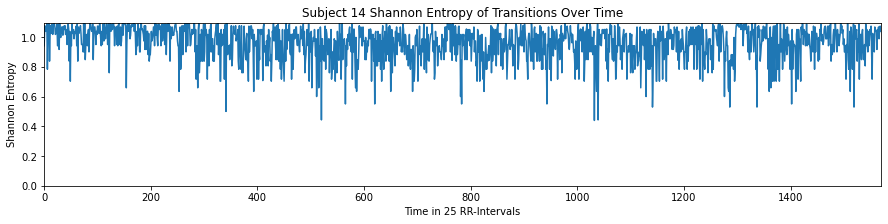

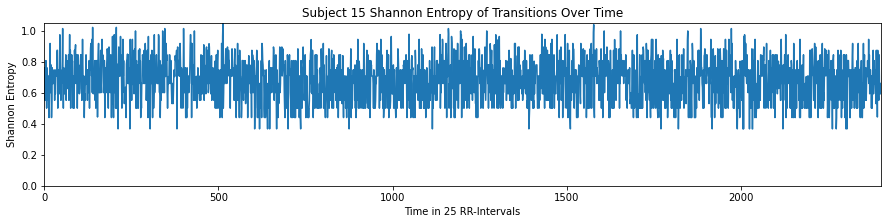

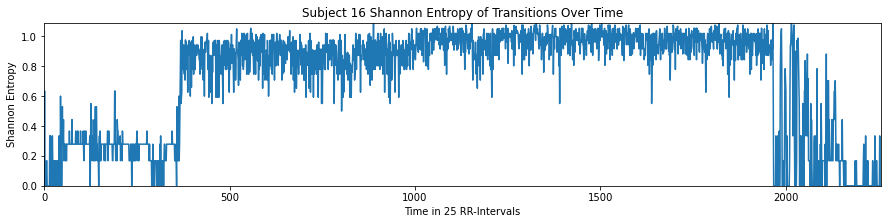

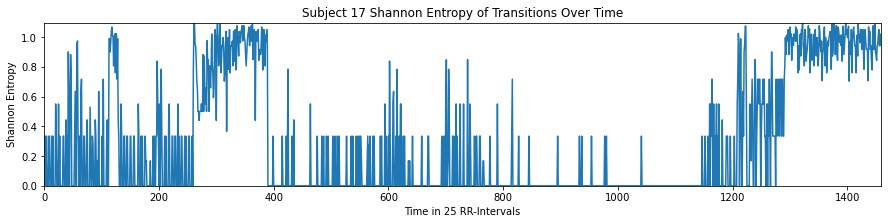

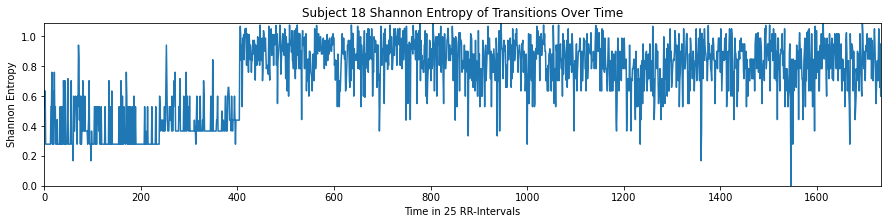

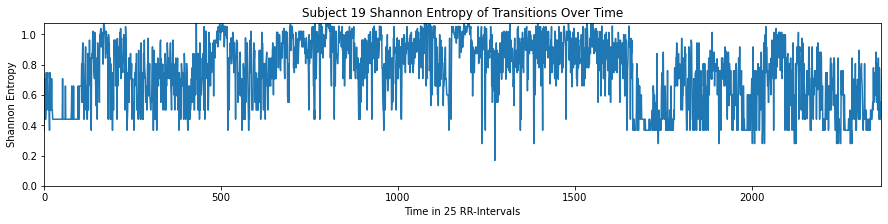

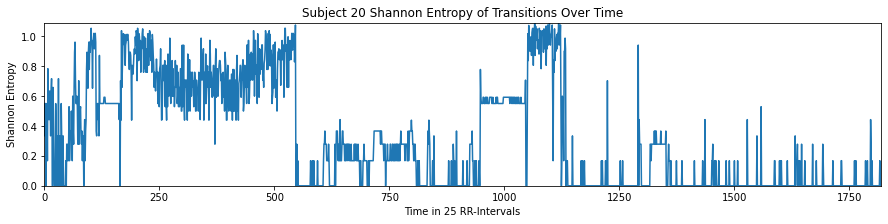

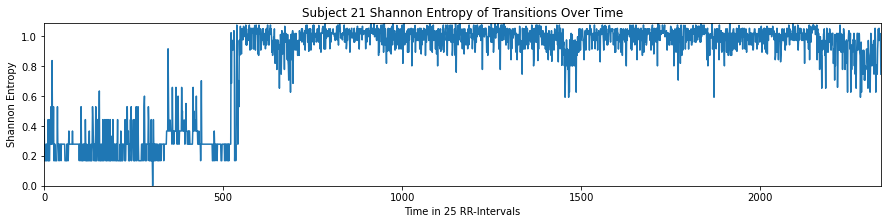

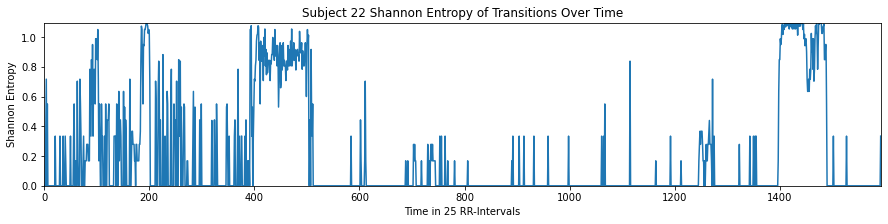

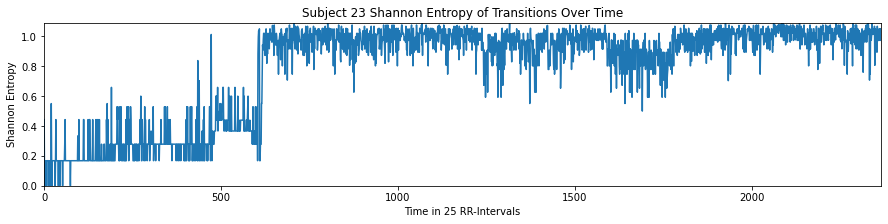

In [121]:
# for index, subject in enumerate(shannon_main):
#     fig, axs = plt.subplots(figsize=(15,3))
#     axs.plot(subject)
#     plt.xlabel('Time in 25 RR-Intervals')
#     plt.ylabel('Shannon Entropy')
#     plt.title('Subject ' + str(index + 1) + ' Shannon Entropy Over Time')
#     axs.set_xlim([0, len(subject)])
#     axs.set_ylim([0, max(subject)])
for index, subject in enumerate(transitionShEntropy_list):
    fig, axs = plt.subplots(figsize=(15,3))
    axs.plot(subject)
    plt.xlabel('Time in 25 RR-Intervals')
    plt.ylabel('Shannon Entropy')
    plt.title('Subject ' + str(index + 1) + ' Shannon Entropy of Transitions Over Time')
    axs.set_xlim([0, len(subject)])
    axs.set_ylim([0, max(subject)])

In [122]:
#Classifying transitions between RR-Ints as short, medium, or long using running mean
int_types = []

for subject in tqdm(subset_dataframes):
    #list of types of rr_ints for each subject
    subject_types = []
    for chunk in subject:
        subset_types = []
        counter = 0
        for rr_ints in chunk['Interval']:
            if rr_ints < 0.85 * chunk['rmean'][counter]: 
                #if rr_ints is less than 85% of runningmean
                #label subject type as short
                subset_types.append('short')
                counter += 1
            elif rr_ints > 1.15 * chunk['rmean'][counter]: 
                #if rr_ints is greater than 115% of runningmean
                #label subject type as long
                subset_types.append('long')
                counter += 1
            else:
                #label subject type as regular
                subset_types.append('regular')
                counter += 1
        subject_types.append(subset_types)
    int_types.append(subject_types)



100%|██████████| 23/23 [00:09<00:00,  2.52it/s]


In [123]:
#Classifying transitions between RR-Ints as short, medium, or long using running mean
transitions_list=[]

for idx, subject in enumerate(int_types): 
    subject_transitions = []
    for j, subset in enumerate(subject):
        StoS, StoR, StoL, RtoS, RtoR, RtoL, LtoS, LtoR, LtoL = [0]*9
        count = 0
        for i, rr_int in enumerate(subset):
            if i<len(subset)-1:
                count += 1
                if subset[i]== 'short' and subset[i+1]== 'short':
                  #if subset is short to short
                  #add one to the StoS counter
                    StoS += 1

                elif subset[i]== 'short' and subset[i+1]== 'regular':
                  #if subset is short to regular
                  #add one to the StoR counter
                    StoR += 1

                elif subset[i]== 'short' and subset[i+1]== 'long':
                  #if subset is short to long
                  #add one to the StoL counter
                    StoL += 1
                    
                elif subset[i]== 'regular' and subset[i+1]== 'regular':
                  #if subset is short to short
                  #add one to the StoS counter
                    RtoR += 1

                elif subset[i]== 'regular' and subset[i+1]== 'long':
                  #if subset is short to regular
                  #add one to the StoR counter
                    RtoL += 1

                elif subset[i]== 'regular' and subset[i+1]== 'short':
                  #if subset is short to long
                  #add one to the StoL counter
                    RtoS += 1
                    
                elif subset[i]== 'long' and subset[i+1]== 'short':
                  #if subset is short to short
                  #add one to the StoS counter
                    LtoS += 1

                elif subset[i]== 'long' and subset[i+1]== 'regular':
                  #if subset is short to regular
                  #add one to the StoR counter
                    LtoR += 1

                elif subset[i]== 'long' and subset[i+1]== 'long':
                  #if subset is short to long
                  #add one to the StoL counter
                    LtoL += 1

                #repeat for... 
                #regular to short
                #regular to regular
                #regular to long
                #long to short
                #long to regular
                #long to long
        subject_transitions.append([StoS/count, StoR/count, StoL/count, RtoS/count, RtoR/count, RtoL/count, LtoS/count, LtoR/count, LtoL/count])
    transitions_list.append(subject_transitions)

In [124]:
#Standard deviation
Std_list = []
for subject in subset_dataframes:
    Standard_devs = []
    for chunk in subject:
        standard_dev = np.std(chunk['Interval'])
        Standard_devs.append(standard_dev)
    Std_list.append(Standard_devs)

In [125]:
CoefVar_list = []
for subject in subset_dataframes:
    variance_list = []
    for chunk in subject:
        variance = np.std(chunk['Interval'])/np.mean(chunk['Interval'])
        variance_list.append(variance)
    CoefVar_list.append(variance_list)

In [126]:
Range_list = []
for subject in subset_dataframes:
    range_array = []
    for chunk in subject:
        ranges = max(chunk['Interval']) - min(chunk['Interval'])
        range_array.append(ranges)
    Range_list.append(range_array)

In [127]:
def difference_count(vector, m, r):
    vector_list = []
    temp_list = []
    master_arr = []
    for idx, pos in enumerate(vector):
        if (idx+m) > len(vector):
            break
        for i in range(idx, idx+m):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

#         elif (idx + 1) == len(vector):
#             vector_list.append(temp_list)
#             temp_list = []

    for i in range(0, len(vector_list)):
        count = 0
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m:    
                for num in range(0, m):
                    diff = vector_list[j][num] - vector_list[i][num]
                    difference_list.append(abs(diff))
#             else:        
#                 if len(vector_list[i]) < len(vector_list[j]):
#                     for num in range(0, len(vector_list[i])):
#                         diff = vector_list[j][num] - vector_list[i][num]
#                         difference_list.append(abs(diff))
#                 else:
#                     for num in range(0, len(vector_list[j])):
#                         diff = vector_list[j][num] - vector_list[i][num]
#                         difference_list.append(abs(diff))
            if max(difference_list) <= r:
                count += 1
                
        master_arr.append(count)
    return master_arr

def app_entropy(vector, m, r):
    N = len(vector)
    master_arr = difference_count(vector, m, r)
    summation = 0
    for i in range(0, len(master_arr)):
        value = np.log(master_arr[i]/(N-m+1))
        summation += value
    
    app1 = summation / (N - m + 1)
    
    N = len(vector)
    master_arr = difference_count(vector, m+1, r)
    summation = 0
    for i in range(0, len(master_arr)):
        value = np.log(master_arr[i]/(N-m+1-1))
        summation += value
    
    app2 = summation / (N - m - 1 + 1)
    
    return  app1 - app2

def samp_entropy(vector, m, r):
    mplusone = m + 1
    num_arr = difference_count(vector, mplusone, r)
    denom_arr = difference_count(vector, m, r)
    numerator = 0
    denom = 0

    for i in range(0, len(num_arr)):
        value = num_arr[i] - 1
        numerator += value
    for i in range(0, len(denom_arr)):
        value = denom_arr[i] - 1
        denom += value
    return -np.log(numerator/denom)

In [202]:
def range_entropy_a(vector, m, r):
    vector_list = []
    temp_list = []
    master_arr = []
    range_value = 0
    
    for idx, pos in enumerate(vector):
        if (idx+m) > len(vector):
            break
        for i in range(idx, idx+m):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

    
    for i in range(0, len(vector_list)):
        higher_diff_list = []
        
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m:    
                for num in range(0, m):
                    diff = vector_list[j][num] - vector_list[i][num]
                    difference_list.append(abs(diff))
                    
            higher_diff_list.append(max(difference_list))

            
        higher_diff_list.remove(0)
        range_dis = (max(higher_diff_list) - min(higher_diff_list)) / (max(higher_diff_list) + min(higher_diff_list) + 0.000000000000000001)
        print(range_dis)
        if (r-range_dis) >= 0:
            range_value += 1
    return range_value
                                     

In [206]:
def range_entropy_a(vector, m, r):
    vector_list = []
    temp_list = []
    master_arr = []
    range_value = 0
    
    for idx, pos in enumerate(vector):
        if (idx+m) > len(vector):
            break
        for i in range(idx, idx+m):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

    
    for i in range(0, len(vector_list)):
        higher_diff_list = []
        temp_range = 0
        
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m:    
                for num in range(0, m):
                    diff = vector_list[j][num] - vector_list[i][num]
                    difference_list.append(abs(diff))
            
            range_dis = (max(difference_list) - min(difference_list)) / (max(difference_list) + min(difference_list) + 0.000000000000000001)
            higher_diff_list.append(range_dis)
            if (r-range_dis) >= 0:
                temp_range += 1
            
        range_value += temp_range/(len(vector)-m)

    return range_value
                                     

In [129]:
def entropy_af_preparation(vector, m, r, n):
    vector_list = []
    temp_list = []
    master_arr = []
    range_value = 0
    
    for idx, pos in enumerate(vector):
        if (idx+m) > len(vector):
            break
        for i in range(idx, idx+m):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

    
    for i in range(0, len(vector_list)):
        higher_diff_list = []
        DX = 0
        
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m:    
                for num in range(0, m):
                    diff = vector_list[j][num] - vector_list[i][num]
                    difference_list.append(abs(diff))
            
            range_dis = (max(difference_list) - min(difference_list)) / (max(difference_list) + min(difference_list) + 0.000000000000000001)
            higher_diff_list.append(range_dis)
            
            
        higher_diff_list.remove(0)
        for val in higher_diff_list:
            DX += np.exp(-(val**n)/r)
        DX / (len(vector) - m)
        master_arr.append(DX)
    
    BX = sum(master_arr) / (len(vector) - m)
    
    
    
    
    #AX
    vector_list = []
    temp_list = []
    master_arr = []
    range_value = 0
    
    for idx, pos in enumerate(vector):
        if (idx+m+1) > len(vector):
            break
        for i in range(idx, idx+m+1):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

    
    for i in range(0, len(vector_list)):
        higher_diff_list = []
        DX = 0
        
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == (m+1):    
                for num in range(0, (m+1)):
                    diff = vector_list[j][num] - vector_list[i][num]
                    difference_list.append(abs(diff))
            
            range_dis = (max(difference_list) - min(difference_list)) / (max(difference_list) + min(difference_list) + 0.000000000000000001)
            higher_diff_list.append(range_dis)
            
        if 0 in higher_diff_list:    
            higher_diff_list.remove(0)
        
        for val in higher_diff_list:
            DX += np.exp(-(val**n)/r)
        DX / (len(vector) - m)
        master_arr.append(DX)
    
    AX = sum(master_arr) / (len(vector) - m)
    
    return [BX,AX]

def entropy_af_calculation(BX,AX,m,r,w,rrmean):
#     print(AX,BX,(-np.log(AX/BX) + np.log(2*r) - w * np.log(rrmean)))
    return (-np.log(AX/BX) + np.log(2*r) - w * np.log(rrmean))

In [130]:
def fuzzy_preparation(vector, m, r, n):
    vector_list = []
    temp_list = []
    master_arr = []
    range_value = 0
    
    for idx, pos in enumerate(vector):
        if (idx+m) > len(vector):
            break
        for i in range(idx, idx+m):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

    
    for i in range(0, len(vector_list)):
        higher_diff_list = []
        DX = 0
        
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m:   
                range_dis = abs( (max(vector_list[i]) - sum(vector_list[i])/m) - (max(vector_list[j]) - sum(vector_list[j])/m))
                higher_diff_list.append(range_dis)
            
            
        for val in higher_diff_list:
            DX += np.exp(-(val**n)/r)
        DX / (len(vector) - m - 1)
        master_arr.append(DX)
    
    BX = sum(master_arr) / (len(vector) - m)
    
    
    
    
    
    #X(m+1)
    vector_list = []
    temp_list = []
    master_arr = []
    range_value = 0
    
    for idx, pos in enumerate(vector):
        if (idx+m+1) > len(vector):
            break
        for i in range(idx, idx+m+1):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []

    
    for i in range(0, len(vector_list)):
        higher_diff_list = []
        DX = 0
        
        for j in range(0, len(vector_list)):
            difference_list = []
            
            if len(vector_list[i]) == len(vector_list[j]) == m+1:   
                range_dis = abs( (max(vector_list[i]) - sum(vector_list[i])/(m+1)) - (max(vector_list[j]) - sum(vector_list[j])/(m+1)))
                higher_diff_list.append(range_dis)
            
            
        for val in higher_diff_list:
            DX += np.exp(-(val**n)/r)
        DX / (len(vector) - m - 1)
        master_arr.append(DX)
    
    AX = sum(master_arr) / (len(vector) - m)
    return [BX,AX]

def fuzzy_calculation(BX,AX):
    return np.log(BX) - np.log(AX)

In [397]:
import itertools
import math
import scipy.stats as ss

#Creates and returns a dictionary with keys as all possible permutations for D numbers
#Ex. [1,2,3] has 6 possible arrangements. So 6 keys and 6 values (all values start as 0)
def create_order_dict(D):
    order_sample = list(range(1,D+1))
    permutations_order_list = list(itertools.permutations(order_sample))
    values_to_convert_to_dict = [0] * math.factorial(D)
    orders_dictionary = dict(zip(permutations_order_list,values_to_convert_to_dict))
    return orders_dictionary

#Input the entire vector as a list, the length D of each smaller vector, and t, the time delay.
#The last parameter is the order dictionary
#Returns the shannon entropy of each occurence of each order
def permutation_entropy(vector, D, t,order_dictionary):
    vector_list = []
    temp_list = []
    probability_list = []
    shannon_value = 0
    
    #Create vectors with length D and sliding window of t = 1. 
    #See next block of code to see how the function handles a different t
    for idx, pos in enumerate(vector):
        if (idx+D) > len(vector):
            break
        for i in range(idx, idx+D):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []
    
    #Time delay affects how many of the vectors are used. Vector list uses a sliding window of 1 so 
    #this uses step size based on time delay to change how many vectors are used
    vector_list = vector_list[::t]
    
    #Rank data. If there are ties, break them based on which one occurs first (method='ordinal')
    for permutation in vector_list:
        arr = ss.rankdata(permutation, method='ordinal')
        order_tuple = tuple(arr)
        order_dictionary[order_tuple] += 1
    
    #Gets each count of each order in dict and appends to a list
    for key,val in order_dictionary.items():
        probability_list.append(val)
    
    total = sum(probability_list)
    
    #Converts count --> probability
    probability_list_actual = [count/total for count in probability_list]        
    
    #Use individual probabilities to calculate Shannon Entropy
    for val in probability_list_actual: #Warnings with np.log(0)
        if val == 0:
            continue
        else:
            shannon_value += val * np.log(val)
    
    return (-shannon_value)

In [398]:
def bubble_entropy(vector, D, t,order_dictionary):
    vector_list = []
    temp_list = []
    probability_list = []
    shannon_value = 0
    
    #Create vectors with length D and sliding window of t = 1. 
    #See next block of code to see how the function handles a different t
    for idx, pos in enumerate(vector):
        if (idx+D) > len(vector):
            break
        for i in range(idx, idx+D):
            temp_list.append(vector[i])
        vector_list.append(temp_list)
        temp_list = []
    
    #Time delay affects how many of the vectors are used. Vector list uses a sliding window of 1 so 
    #this uses step size based on time delay to change how many vectors are used
    vector_list = vector_list[::t]
    
    #Rank data. If there are ties, break them based on which one occurs first (method='ordinal')
    for permutation in vector_list:
        arr = ss.rankdata(permutation, method='ordinal')
        order_tuple = tuple(arr)
        order_dictionary[order_tuple] += 1
    
    #Gets each count of each order in dict and appends to a list
    for key,val in order_dictionary.items():
        probability_list.append(val)
    
    total = sum(probability_list)
    
    #Converts count --> probability
    probability_list_actual = [count/total for count in probability_list]        
    
    #Use individual probabilities to calculate Shannon Entropy
    for val in probability_list_actual: #Warnings with np.log(0)
        shannon_value += val**2
    
    return (-np.log(shannon_value))

In [423]:
def coarse_grain(time_series, t):
    """
    Coarse grain a time series.
    
    Parameters:
    time_series : list or array-like
        The time series to coarse grain.
    t : int
        The scale factor.
        
    Returns:
    coarse_grained_series : np.ndarray
        The coarse grained time series.
    """
    
    # Convert to array if not already
    if not isinstance(time_series, np.ndarray):
        time_series = np.array(time_series)
        
    # If the length of the time series is not evenly divisible by t,
    # trim off the excess elements
    if len(time_series) % t != 0:
        time_series = time_series[:-(len(time_series) % t)]
    
    # Reshape into an array with size (N/t, t)
    reshaped_series = time_series.reshape((-1, t))
    
    # Calculate the mean along the second axis (i.e., average each window)
    coarse_grained_series = reshaped_series.mean(axis=1)
    
    return coarse_grained_series


In [131]:
subject_main = pd.concat(subject_list, ignore_index = True)
r_std = np.std(subject_main['Interval']) #CALCULATE R
r_std = r_std/2
mylist = difference_count(subset_dataframes[0][0]["Interval"],2,r_std)
print(mylist)
len(mylist)
print(r_std)

[5, 4, 4, 6, 4, 3, 6, 4, 4, 6, 6, 5, 5, 3, 7, 6, 2, 1, 4, 1, 6, 4, 6, 4]
0.09954831137771965


In [278]:
# subject_main = pd.concat(subject_list, ignore_index = True)
# r_std = np.std(subject_main['Interval']) #CALCULATE R
# r_std = r_std/2
# mylist = difference_count(subset_dataframes[0][0]["Interval"],2,r_std)
# print(mylist)
# len(mylist)
# print(r_std)

# AppEn and SampEn

In [132]:
appen_main = []
sampen_main = []
for subject in tqdm(subset_dataframes):
    temp_app_arr = []
    temp_samp_arr = []
    for subsection in subject:
        difference_count(subsection['Interval'], 1, r_std)
        temp_app = app_entropy(subsection['Interval'], 1, r_std)
        temp_samp = samp_entropy(subsection['Interval'], 1, r_std)
        temp_app_arr.append(temp_app)
        temp_samp_arr.append(temp_samp)
    appen_main.append(temp_app_arr)
    sampen_main.append(temp_samp_arr)

100%|██████████| 23/23 [02:41<00:00,  7.03s/it]


# COSEn

In [133]:
cosen_main = []
for subject in tqdm(subset_dataframes):
    temp_samp_arr = []
    for subsection in subject:
        difference_count(subsection['Interval'], 1, r_std)
        temp_samp = samp_entropy(subsection['Interval'], 1, r_std)
        temp_samp = temp_samp + np.log(2*r_std)
        temp_samp_arr.append(temp_samp)
    cosen_main.append(temp_samp_arr)

100%|██████████| 23/23 [01:29<00:00,  3.88s/it]


# Range Entropy

In [223]:
rangeen_main = []
counter = 0
for subject in tqdm(subset_dataframes):
#     if counter != 3:
#         counter += 1
#         continue
    temp_range_arr = []
    for subsection in subject:
        a = range_entropy_a(subsection['Interval'], 2, 0.95)
        temp_range_arr.append(a)
    rangeen_main.append(temp_range_arr)

100%|██████████| 23/23 [01:14<00:00,  3.22s/it]


# Entropy AF

In [135]:
#r=0.1, n = 1, w = 0.8 or 0.5
#try r = 0.05 weight = 0, 0.5
#try r = 0.1 weight = 0
#best is r=0.05, weight = 0.25, n=1, m=1
afen_main = []
r = 0.05
weight = 0.25
n = 1
for subject in tqdm(subset_dataframes):
    temp_af_arr = []
    for subsection in subject:
        BX, AX = entropy_af_preparation(subsection['Interval'], 1, r, n)
        rrmean = np.mean(subsection["Interval"])
        AF = entropy_af_calculation(BX,AX,1,r,weight,rrmean)
#         print(AF+rrmean*weight)
#         print(rrmean*weight)
#         print(np.log(AX/BX))
        
        temp_af_arr.append(AF)
    afen_main.append(temp_af_arr)

100%|██████████| 23/23 [02:57<00:00,  7.71s/it]


# Fuzzy Entropy

In [233]:
fuzzyen_main = []
r = 1
n=1
for subject in tqdm(subset_dataframes):
    temp_af_arr = []
    for subsection in subject:
        BX, AX = fuzzy_preparation(subsection['Interval'], 2, r, n)
        AF = fuzzy_calculation(BX,AX)
        
        temp_af_arr.append(AF)
    fuzzyen_main.append(temp_af_arr)

100%|██████████| 23/23 [02:57<00:00,  7.70s/it]


# Permutation Entropy

In [395]:
#Best of 5,6,7 maybe 4
D = 4
orders_dict = create_order_dict(D)

perm_main = []
for subject in tqdm(subset_dataframes):
    temp_perm_arr = []
    for subsection in subject:
        temp_samp = permutation_entropy(subsection['Interval'], D, 1, orders_dict)
        orders_dict = {key: 0 for key in orders_dict}
        temp_perm_arr.append(temp_samp)
    perm_main.append(temp_perm_arr)

100%|██████████| 23/23 [00:22<00:00,  1.03it/s]


# Bubble Entropy

In [416]:
D = 3
orders_dict1 = create_order_dict(D)
orders_dict2 = create_order_dict(D+1)

bubble_main = []
for subject in tqdm(subset_dataframes):
    temp_bubble_arr = []
    for subsection in subject:
        
        temp_bubble1 = permutation_entropy(subsection['Interval'], D, 1, orders_dict1)
        temp_bubble2 = permutation_entropy(subsection['Interval'], D+1, 1, orders_dict2)
        
        orders_dict1 = {key: 0 for key in orders_dict1}
        orders_dict2 = {key: 0 for key in orders_dict2}
        
        bubble_value = (temp_bubble2 - temp_bubble1)/(np.log((D+1)/(D-1)))
        
        temp_bubble_arr.append(bubble_value)
        
    bubble_main.append(temp_bubble_arr)

100%|██████████| 23/23 [00:42<00:00,  1.85s/it]


# Multiscale Entropy

In [444]:
multi_main1 = []
# multi_main2 = []
# multi_main3 = []
# multi_main4 = []

for subject in tqdm(subset_dataframes):
    temp_main1 = []
#     temp_main2 = []
#     temp_main3 = []
#     temp_main4 = []
    for subsection in subject:
        
        temp_chunk2 = coarse_grain(subsection['Interval'],2)
        temp_chunk3 = coarse_grain(subsection['Interval'],3)
        temp_chunk4 = coarse_grain(subsection['Interval'],4)
        
        temp_samp1 = samp_entropy(subsection['Interval'], 1, r_std)
        temp_samp2 = samp_entropy(temp_chunk2, 1, r_std)
        temp_samp3 = samp_entropy(temp_chunk3, 1, r_std)
        temp_samp4 = samp_entropy(temp_chunk4, 1, r_std)
        
        temp_samp_mean = np.mean([temp_samp1,temp_samp2,temp_samp3,temp_samp4])
        
        #in cases where temp_samp_mean is "inf", which is a numpy.float64 object (cannot be handled by sklearn)
        if np.isinf(temp_samp_mean):
            temp_samp_mean = 100
        
        temp_main1.append(temp_samp_mean)

    multi_main1.append(temp_main1)

  0%|          | 0/23 [00:00<?, ?it/s]<ipython-input-127-2a742820382e>:75: RuntimeWarning: divide by zero encountered in log
  return -np.log(numerator/denom)
100%|██████████| 23/23 [01:30<00:00,  3.91s/it]


# Other Features ex. iqr, variance, rmean variance, etc.

In [137]:
iqr_main = []
for subject in tqdm(subset_dataframes): #IQR
    temp_iqr = []
    for subsection in subject:
        q75, q25 = np.percentile(subsection['Interval'], [75 ,25])
        tempvar = q75 - q25
        temp_iqr.append(tempvar)
    iqr_main.append(temp_iqr)

100%|██████████| 23/23 [00:03<00:00,  6.40it/s]


In [138]:
var_main = [] #variance
for subject in tqdm(subset_dataframes):
    temp_variance = []
    for subsection in subject:
        tempvar = np.var(subsection['Interval'])
        temp_variance.append(tempvar)
    var_main.append(temp_variance)

100%|██████████| 23/23 [00:01<00:00, 14.23it/s]


In [139]:
rmean_var_main = [] #rmean variance
for subject in tqdm(subset_dataframes):
    temp_rmean = []
    for subsection in subject:
        tempvar = np.var(subsection['rmean'])
        temp_rmean.append(tempvar)
    rmean_var_main.append(temp_rmean)

100%|██████████| 23/23 [00:01<00:00, 14.39it/s]


In [140]:
def mad(data, axis=None):
    return mean(absolute(data - mean(data, axis)), axis)

mad_main = [] #Mean Absolute Deviation
for subject in tqdm(subset_dataframes):
    temp_mad = []
    for subsection in subject:
        tempvar = mad(subsection['Interval'])
        temp_mad.append(tempvar)
    mad_main.append(temp_mad)

100%|██████████| 23/23 [00:11<00:00,  1.95it/s]


In [142]:
def rmssd(chunk, length):
    tempsum = []
    anothersum = 0
    for idx, interval in enumerate(chunk):
        if idx == 0:
            continue
        else:
            tempsum.append((interval - chunk[idx-1])**2)
    for item in tempsum:
        anothersum += item
    
    anothersum = ((1/(length-1)) * anothersum)**0.5
    
    return anothersum

rmssd_main = [] #rmssd
for subject in tqdm(subset_dataframes):
    temp_rmssd = []
    for subsection in subject:
        tempsum = rmssd(subsection['Interval'], 25)
        temp_rmssd.append(tempsum)
    rmssd_main.append(temp_rmssd)

100%|██████████| 23/23 [00:03<00:00,  6.61it/s]


# Compare AFIB to Non AFIB for individual features

<ipython-input-455-8089b7350d4f>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize=(15,3))


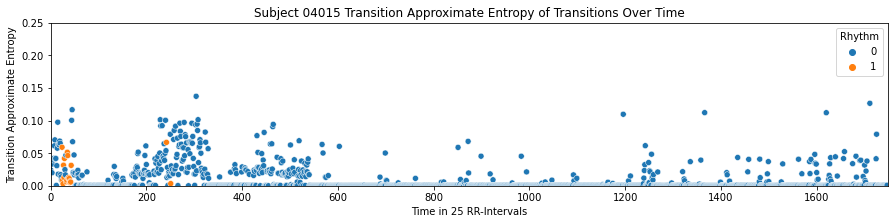

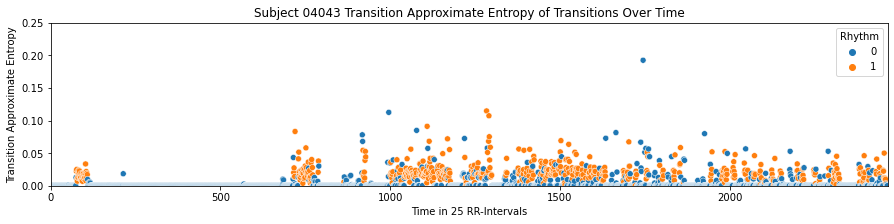

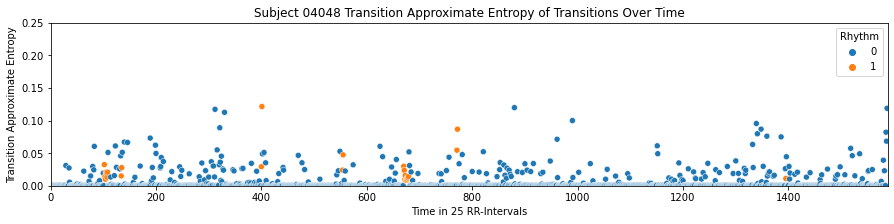

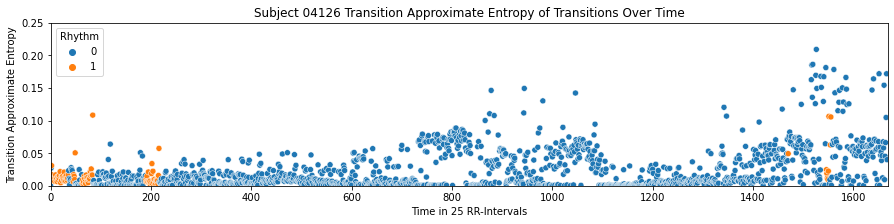

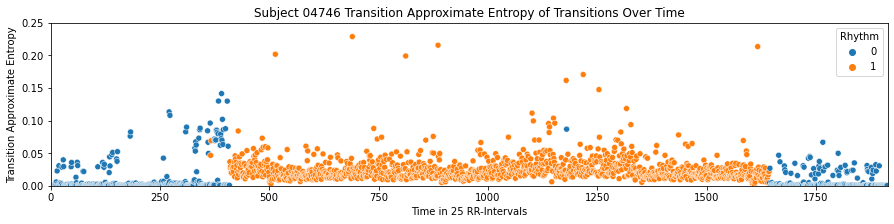

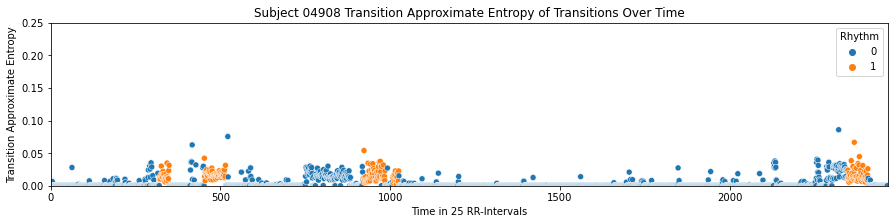

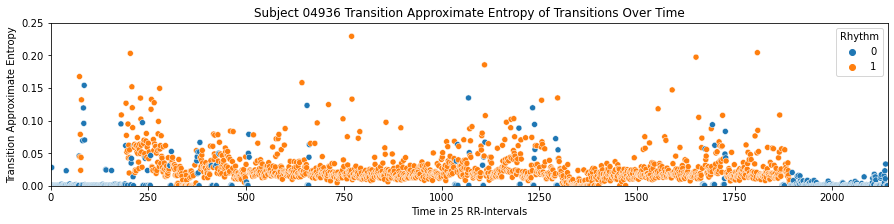

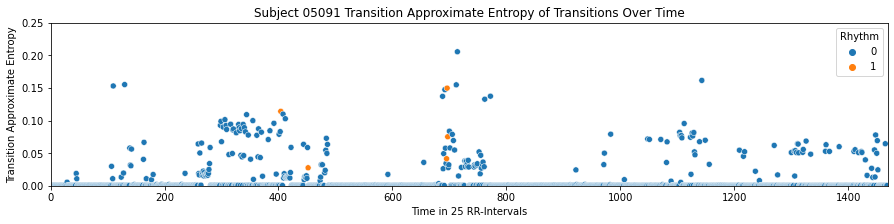

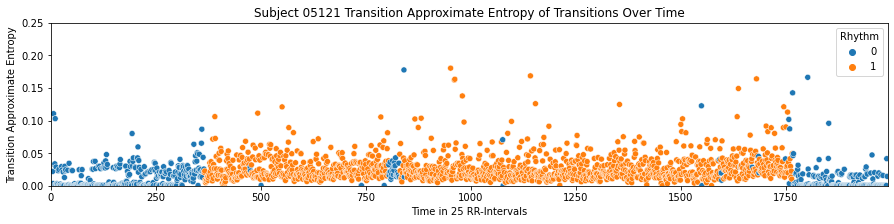

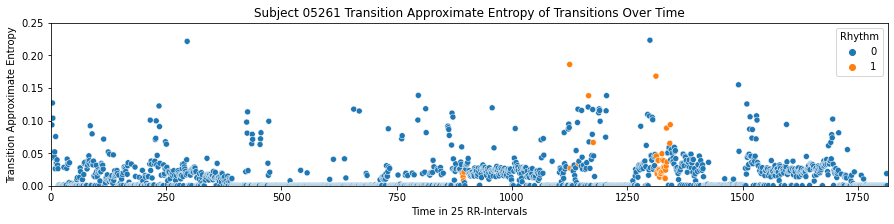

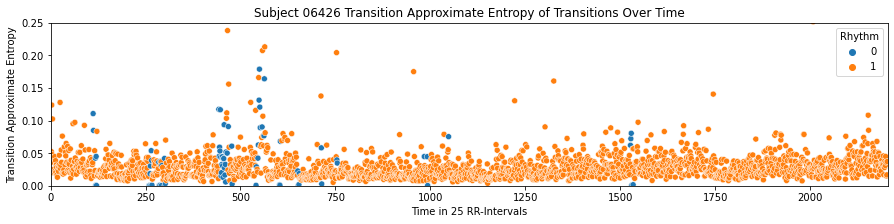

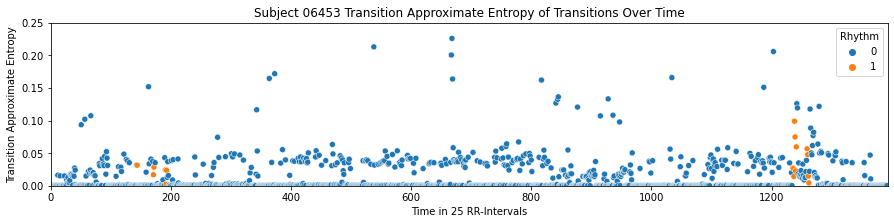

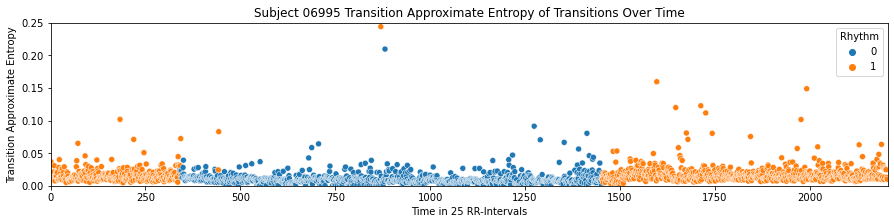

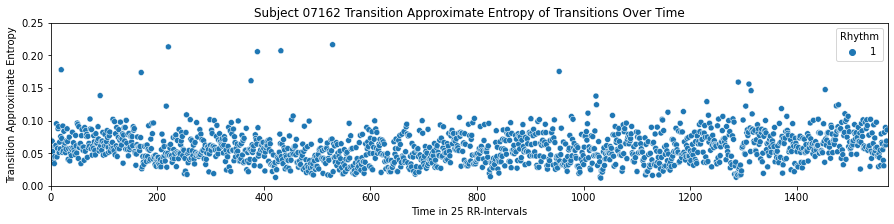

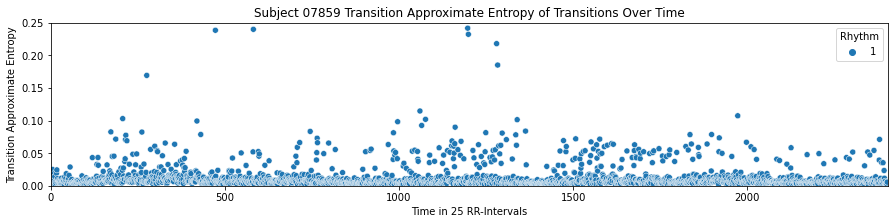

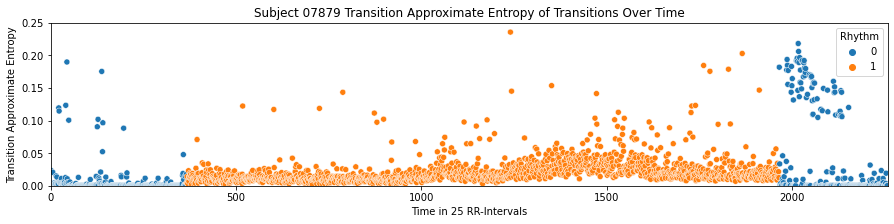

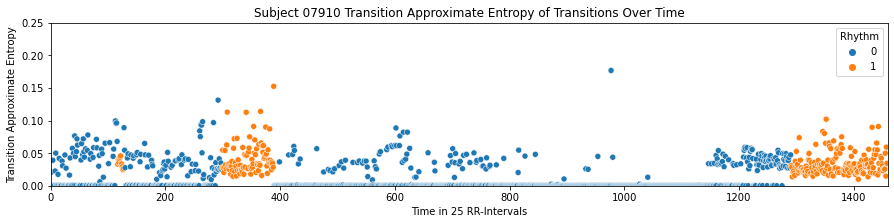

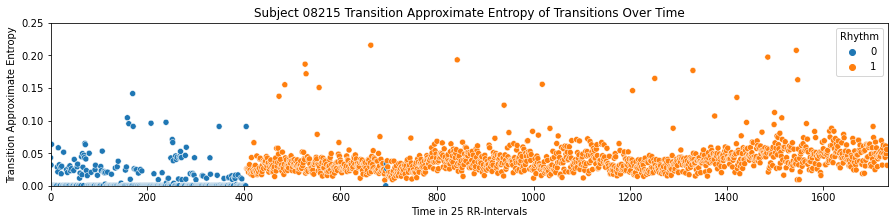

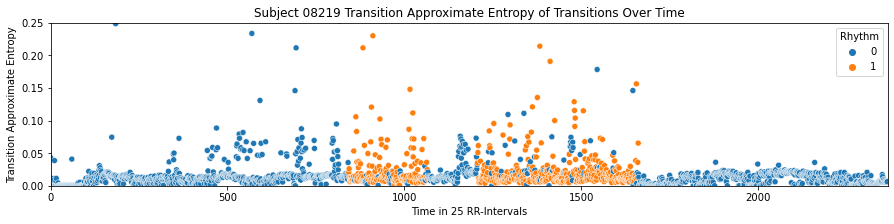

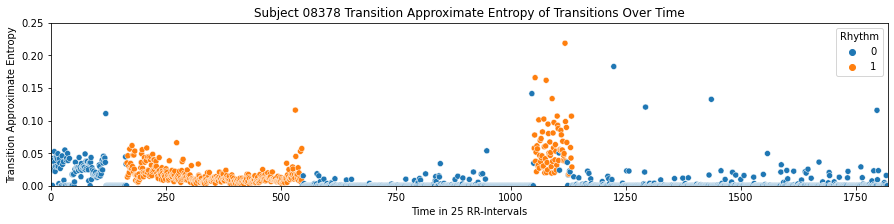

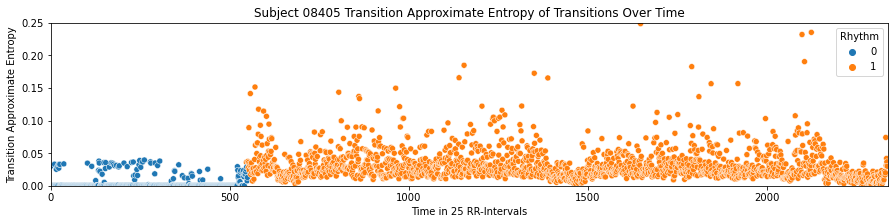

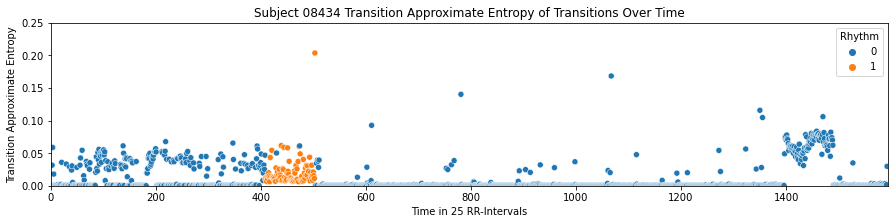

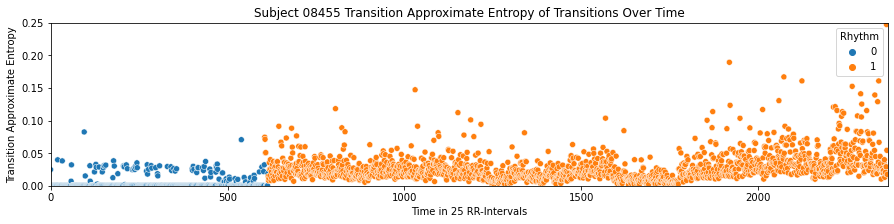

In [455]:
for index, subject in enumerate(volatility_main):
    fig, axs = plt.subplots(figsize=(15,3))
    #axs.plot(subject)
    
    sns.scatterplot(x=features_model[index].index,y="Volatility", hue="Rhythm", data=features_model[index])
    
    plt.xlabel('Time in 25 RR-Intervals')
    plt.ylabel('Transition Approximate Entropy')
    plt.title('Subject ' + str(record_list[index]) + ' Transition Approximate Entropy of Transitions Over Time')
    axs.set_xlim([0, len(subject)])
    axs.set_ylim([0, 0.25])

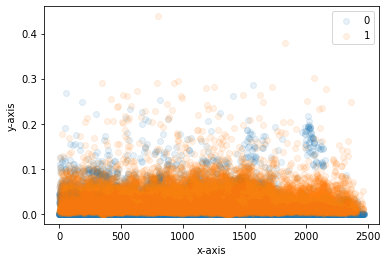

In [452]:
total_subject_df = pd.concat(features_model)

# Get unique categories and their corresponding colors
categories = total_subject_df['Rhythm'].unique()
colors = plt.cm.viridis(range(len(categories)))

# Create the line plot
fig, ax = plt.subplots()
for i, category in enumerate(categories):
    df_cat = total_subject_df[total_subject_df['Rhythm'] == category]
    ax.scatter(df_cat.index, df_cat['Volatility'], label=category,alpha=0.1)

# Add legend and labels
ax.legend()
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')

# Show the plot
plt.show()

# Create Rhythm Assignment and Compile Features into DF

In [145]:
rhythm_main = [] #A-FIB = 1, Non A-FIB = 0
for subject in tqdm(subset_dataframes):
    subject_temp = []
    for subsection in subject:
        afib_counter = 0
        non_afibcounter = 0
        for rhythm in subsection['Rhythm']:
            if rhythm == 'A':
                afib_counter += 1
            else:
                non_afibcounter +=1
        if afib_counter > non_afibcounter:
            subject_temp.append(1)
        else:
            subject_temp.append(0)
    rhythm_main.append(subject_temp)

100%|██████████| 23/23 [00:02<00:00,  7.78it/s]


In [450]:
features_model = []
counter = -1

for subject in subset_dataframes:
    counter += 1

    tempdf = pd.DataFrame()
#     tempdf = pd.DataFrame(
                                
#         data = np.transpose(np.array([
#                                         [x[0] for x in transitions_list[counter]],
#                                         [x[1] for x in transitions_list[counter]],
#                                         [x[2] for x in transitions_list[counter]],
#                                         [x[3] for x in transitions_list[counter]],
#                                         [x[4] for x in transitions_list[counter]],
#                                         [x[5] for x in transitions_list[counter]],
#                                         [x[6] for x in transitions_list[counter]],
#                                         [x[7] for x in transitions_list[counter]],
#                                         [x[8] for x in transitions_list[counter]],
#                                         Std_list[counter],
#                                         CoefVar_list[counter],
#                                         Range_list[counter],
#                                         volatility_main[counter],
#                                         transitionShEntropy_list[counter]
#                                         ])
#                                ),


#         columns = ['StoS', 'StoR', 'StoL', 'RtoS', 'RtoR', 'RtoL', 'LtoS', 'LtoR', 'LtoL', 'STD', 'CoefVar', 'Range', 'Volatility', 'ShEn']
        
        
#     )
    tempvar1 = appen_main[counter]
    tempvar2 = sampen_main[counter]

    tempdf = tempdf.assign(AppEn=tempvar1)
    tempdf = tempdf.assign(SampEn=tempvar2)
#     tempdf = tempdf.assign(IQR=iqr_main[counter])
#     tempdf = tempdf.assign(Var=var_main[counter])
#     tempdf = tempdf.assign(Rmean_Var=rmean_var_main[counter])
    tempdf = tempdf.assign(CosEn=cosen_main[counter])
    tempdf = tempdf.assign(RangeEn=rangeen_main[counter])
    tempdf = tempdf.assign(FuzzyEn=fuzzyen_main[counter])
    tempdf = tempdf.assign(EntropyAF=afen_main[counter])
    tempdf = tempdf.assign(PermEn=perm_main[counter])
    tempdf = tempdf.assign(BubbleEn=bubble_main[counter])
    tempdf = tempdf.assign(MultiscaleEn=multi_main1[counter])
    tempdf = tempdf.assign(Volatility=volatility_main[counter])
    tempdf = tempdf.assign(Rhythm=rhythm_main[counter])
    
    features_model.append(tempdf)

In [451]:
features_model[0]

AppEn    SampEn     CosEn    RangeEn   FuzzyEn  EntropyAF    PermEn  \
0     0.807078  1.004927 -0.609038  24.173913  0.104346   0.264408  2.689178   
1     0.722627  0.867501 -0.746464  24.086957  0.101648   0.161243  2.539367   
2     0.780945  0.871395 -0.742570  23.565217  0.104487   0.089117  2.902002   
3     0.551398  0.559616 -1.054349  24.000000  0.119426   0.126149  2.712962   
4     0.638499  0.850539 -0.763426  23.304348  0.087503   1.000024  2.437125   
...        ...       ...       ...        ...       ...        ...       ...   
1743  0.000000  0.083382 -1.530583  20.695652  0.085013  -0.145519  2.689178   
1744  0.000000  0.083382 -1.530583  22.260870  0.086708   0.154363  2.326543   
1745  0.000000  0.083382 -1.530583  21.217391  0.086220  -0.649682  2.752192   
1746  0.000000  0.083382 -1.530583  21.739130  0.085932  -0.224733  2.200516   
1747  0.003828  0.087315 -1.526650  21.565217  0.087540  -0.050885  2.374111   

      BubbleEn  MultiscaleEn  Volatility  Rhythm  
0     1.354979    100.000000    0.024543       0  
1     1.151478      0.734993    0.034714       0  
2     1.690498      1.045270    0.033321       0  
3     1.446250    100.000000    0.019996       0  
4     1.319674      1.168238    0.033423       0  
...        ...           ...         ...     ...  
1743  1.333665      0.239713    0.000326       0  
1744  0.914422      0.239713    0.000604       0  
1745  1.474367      0.239713    0.000486       0  
1746  1.001454      0.239713    0.000595       0  
1747  1.098484      0.240696    0.000756       0  

[1748 rows x 11 columns]

In [446]:
type(features_model[0]["MultiscaleEn"][0])

numpy.float64

## Save the RR-Intervals 

In [456]:
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:22<00:00,  1.10it/s]


In [457]:
for idx, df in tqdm(enumerate(features_model)):
    tempvar = good_list[idx]
    df.to_csv(f'subject-features-dataframes/subject{tempvar}.csv')

23it [00:00, 39.00it/s]


In [ ]:
#percentage afib and dynamics of data after outliers
#graph of line with outliers
#graph of features

In [ ]:
for idx, df in tqdm(enumerate(features_model2)):
    tempvar = good_list[idx]
    df.to_csv(f'subject-features-dataframes-v2/subject{tempvar}.csv')

## What else to extract - some good places to start

- [Moody, 1983 - A new method for detecting atrial fibrillation using R-R intervals.](http://ecg.mit.edu/george/publications/afib-cinc-1983.pdf)
- [Lake, 2010 - Accurate estimation of entropy in very short physiological time series: the problem of atrial fibrillation detection in implanted ventricular devices](https://journals.physiology.org/doi/full/10.1152/ajpheart.00561.2010)
- [Rubio, 2011 - Estudio comparativo de algoritmos para la deteccion de la fibrilacion auricular](https://academica-e.unavarra.es/bitstream/handle/2454/4136/577570.pdf?sequence=1&isAllowed=y)
- [Ghodrati, 2008 - Statistical analysis of RR interval irregularities for detection of atrial fibrillation](https://ieeexplore.ieee.org/document/4749227)
- [Young, 1999 - A comparative study of a hidden Markov model detector for atrial fibrillation](https://ieeexplore.ieee.org/abstract/document/788166)

In [ ]:
#Entropy Features on Transitions
transition_r = [element for nestedlist in transitions_list for subsection in nestedlist for element in subsection]
trans_r_std = np.std(transition_r) #CALCULATE R
trans_r_std = r_std/16 #0.5 * std dev of transition probabilities

trans_appen_main = []
#trans_sampen_main = []
for subject in tqdm(transitions_list):
    temp_app_arr = []
    temp_samp_arr = []
    for subsection in subject:
        difference_count(subsection, 1, trans_r_std)
        temp_app = app_entropy(subsection, 1, trans_r_std)
#         difference_count(subsection, 1, trans_r_std/4)
#         temp_samp = samp_entropy(subsection, 1, trans_r_std/4)
        temp_app_arr.append(temp_app)
        #temp_samp_arr.append(temp_samp)
    trans_appen_main.append(temp_app_arr)
    #trans_sampen_main.append(temp_samp_arr)

#Entropy Features on Transitions
transition_r = [element for nestedlist in chunk_prob for subsection in nestedlist for element in subsection]
trans_r_std = np.std(transition_r) #CALCULATE R
trans_r_std = r_std*2 #0.5 * std dev of transition probabilities

trans_appen_prob = []
#trans_sampen_main = []
for subject in tqdm(chunk_prob):
    temp_app_arr = []
    temp_samp_arr = []
    for subsection in subject:
        difference_count(subsection, 1, trans_r_std)
        temp_app = app_entropy(subsection, 1, trans_r_std)
#         difference_count(subsection, 1, trans_r_std/4)
#         temp_samp = samp_entropy(subsection, 1, trans_r_std/4)
        temp_app_arr.append(temp_app)
        #temp_samp_arr.append(temp_samp)
    trans_appen_prob.append(temp_app_arr)
    #trans_sampen_main.append(temp_samp_arr)

#Transition Volatility
def trans_vol(chunk):
    mean = np.mean(chunk)
    templist = []
    for value in chunk:
        residual = value - mean
        residual = residual ** 2
        templist.append(residual)
    tempvar = np.std(templist)
    return tempvar


volatility_transitions = []
for subject in tqdm(chunk_prob):
    temp_list = []
    for chunk in subject:
        temp_var = trans_vol(chunk)
        temp_list.append(temp_var)
    volatility_transitions.append(temp_list)

volatility_transitions2 = []
for subject in tqdm(transitions_list):
    temp_list = []
    for chunk in subject:
        temp_var = trans_vol(chunk)
        temp_list.append(temp_var)
    volatility_transitions2.append(temp_list)

N = 25

[0.1,0.2,0.3,...,0.15]

m (vector length) = 2

[0.1,0.2] compare to [0.2,0.3], [0.3,...], [0.2,0.15]

MAXIMUM ABSOLUTE DIFFERENCE

0.2-0.1
0.3-0.2

when m = 1?
0.2-0.1

24 distance function values, sum them based on the heavside function

just take absolute difference (is it less than or equal to r?) --> increase the count

A heavside function because there are only 2 options (either its greather, or less tahn or equal to) --> only outputs are 0 and 1







